<a href="https://colab.research.google.com/github/OlgaShevel/Computer-Vision-Projects/blob/main/!semseg_DeepLab2%2BResNet101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import shutil
from glob import glob
import requests
import zipfile
import cv2
import numpy as np

from PIL import Image

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import albumentations as A
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101
from sklearn.utils import class_weight  # для взвешивания весов классов

Делаю проект, связанный с медицинскими микроизображениями, - они менее 1 см.

Выглядят примерно так в "натуральный" размер с учетом разрешения моего монитора.

На самом деле, это вырезанные из изображений файлов dicom бОльшего размера фрагменты 64х64px.

Фрагменты отражают место, где головка нижней челюсти входит в нижнюю височную впадину.

Задача: найти место с наименьшим расстоянием между головкой и височной костью среди всех срезов (их примерно от 40 до 60 для одного файла dicom). Для этого надо определить границы максимально точно, то есть от одного конкретного пикселя со стороны кости головки до второго конкретного пикселя со стороны впадины.



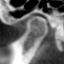

In [ ]:
img_bgr = cv2.imread("/content/drive/MyDrive/0d8.png", cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

Image(filename="/content/drive/MyDrive/0d8.png")


Вряд ли на таких маленьких фото можно что-то измерить с попиксельной точностью. Но мне из метаданных известно межпиксельное пространство, так что без проблем визуально увеличиваю изображение до комфортного для человеческого глаза размера пикселей.

<IPython.core.display.Javascript object>

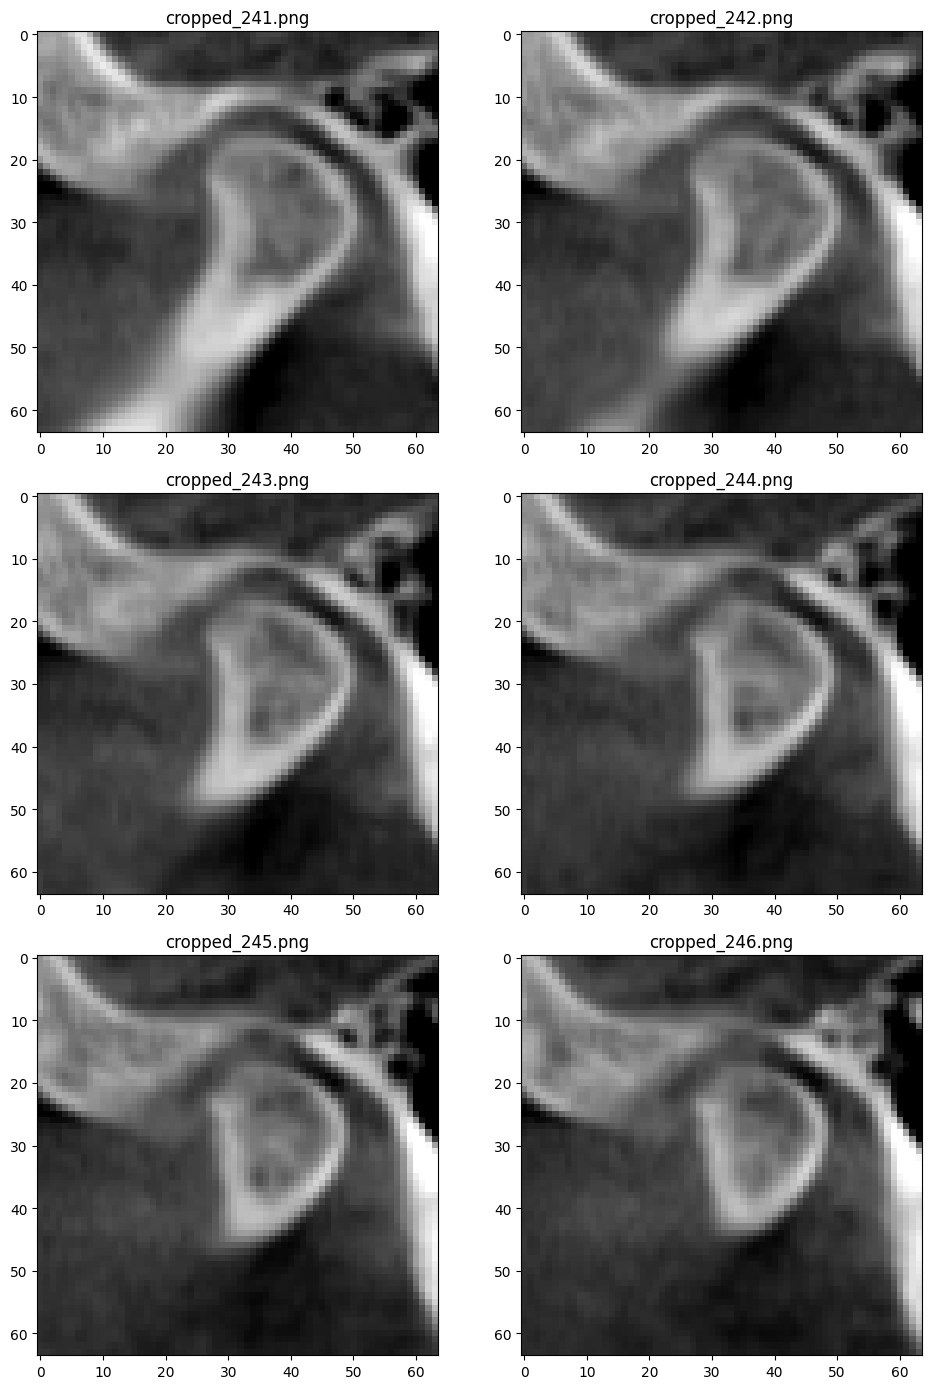

In [ ]:
from google.colab import output
output.no_vertical_scroll()

fig, ax = plt.subplots(3, 2, figsize=(10, 14))

# кадры PNG --------------------------------------------------------------------
sagittal_png = '/content/drive/MyDrive/0.4/!!PROJECT_DICOM_133737/FRAGM/Cropp_Left_64х64'
selected_files = [file for file in os.listdir(sagittal_png) if file.startswith('cropped_') and file.endswith('.png')]
selected_files = sorted(selected_files, key=lambda x: int(x.split('_')[1].split('.')[0]))

images = []
file_names = []

# Изображения в диапазоне 241-246
image_numbers = list(range(241, 247))
for num in image_numbers:
    file_name = f'cropped_{num}.png'
    if file_name in selected_files:
        filepath = os.path.join(sagittal_png, file_name)
        try:
            image = Image.open(filepath)
            images.append(image)
            file_names.append(file_name)
        except FileNotFoundError:
            print(f"Файл не найден: {filepath}")
    else:
        print(f"Файл не найден в списке: {file_name}")

# Индексирую
for i in range(3):
    for j in range(2):
        index = i * 2 + j  # Вычисляем индекс для доступа к изображениям и именам файлов
        if index < len(images):  # Проверяем, что индекс находится в пределах списка
            ax[i, j].imshow(images[index], cmap='gray')
            ax[i, j].set_title(file_names[index])
        else:
            # Если индекс выходит за пределы, то можно оставить подграфик пустым
            ax[i, j].axis('off')  # Отключаем оси, чтобы не отображать ничего

plt.tight_layout()
plt.show()

И вот **первая проблема**: при увеличении на границе классов вылез градиент. Визуально не понятно, где же проходит граница между костью и межкостным пространством?

Первый способ определить границу двух классов на graysale-снимке - ипользовать алгоритмы из библиотек OpenCV и skimage. Но традиционно применяемые для такой задачи алгоритмы с дефолтными настройками (а мне нужна автоматизация, а не ручная настройка) сбоят: Otcu бинарный, Otcu адаптивный, Roberts, Сауvola, Triangle, Sobel и Canny. Просто есть срезы с провалами границы у головки.

Однако без определения границы, причем, максимально точного, не получится решить задачу.

Предполагаю несколько вариантов.

1 - применить алгоритм адаптивного порога, нарпимер, MultiOtcu (пока отложу реализацию в пользу варианта 2).

2 - сделать маски и провести семантическую сегментацию при помощи какой-либо нейросетки. Но... результат неочевиден, и в случае неуспеха уйдет куча времени и усилий на изготовление несколько тысяч мелких масок.

Так что нужен **эксперимент с похожим датасетом**, состоящим из изображений небольшого размера и имеющий 2 класса: объект и фон.

И такая база данных сразу находится: это же всем известный учебный датасет MNIST!

Размер фото в нем 28х28. Пикселизация видна, как и у моих картинок. Маски можно сделать быстро при помощи подбора порога. Так что - подходит. MNIST я намереваюсь подать в построенную с применением фреймворка Tensorflow пару - нейросеть DeepLabv2 + предобученная ResNet101. Так я обучу классификатор, который уже будет выступать в качестве экстрактора признаков, уже на своем датасете.  

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Оригинальный размер тренировочного набора: (60000, 28, 28)
Оригинальный размер тестового набора: (10000, 28, 28)


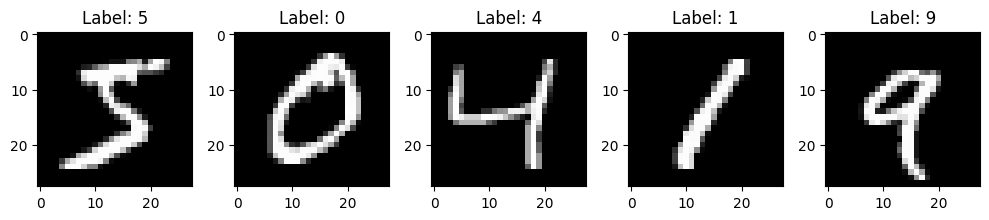

In [ ]:
# Загружаю MNIST и вывожу первые 5 картинок

 (x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f"Оригинальный размер тренировочного набора: {x_train.shape}")
print(f"Оригинальный размер тестового набора: {x_test.shape}")

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
plt.tight_layout()
plt.show()

Замечательно. Мы можем сделать маски и начать обучать нейросетку.

Подбираем для маски значение порога, лучше всего соответствующее изображению. В данном случае это 30.

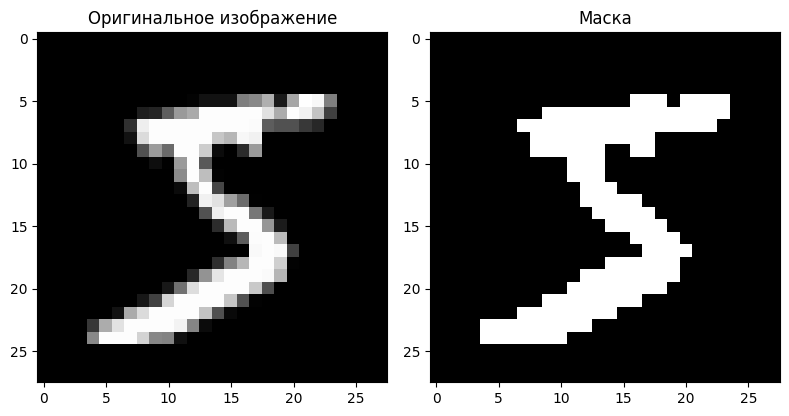

In [ ]:
# Создаем и выводим маску с порогом =30

masks = (x_train > 30).astype(np.uint8)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(x_train[0].squeeze(), cmap='gray')
plt.title("Оригинальное изображение")
plt.subplot(1, 2, 2)
plt.imshow(masks[0].squeeze(), cmap='gray')
plt.title("Маска")

plt.tight_layout()
plt.show()

Но тут появляется **вторая проблема** - минимальное пространственное разрешение изображений, которое может обрабатывать DeepLab, - 32х32px. А в наличии - 28х28px.

Обычно в такой ситуации просто применяют функцию resize() с интерполяционными параметрами и получают нужное разрешение. Фреймворков и библиотек, которые предоставляют инструменты для интерполяции, много, вот некоторые: OpenCV, scikit-image, TensorFlow, SciPy (модуль scipy.interpolate), MATLAB,
Gstat, Akima, Fields, MBA и др.

Поскольку архитектуру нейросети я создаю на базе TensorFlow, логично обратиться к встроенной в фреймворк функции интерполяции. Применим дефолтную билинейную интерполяцию и увеличим разрешение изображение до 32х32px.


Новый размер тренировочного набора: (60000, 32, 32, 3)
Новый размер тестового набора: (10000, 32, 32, 3)


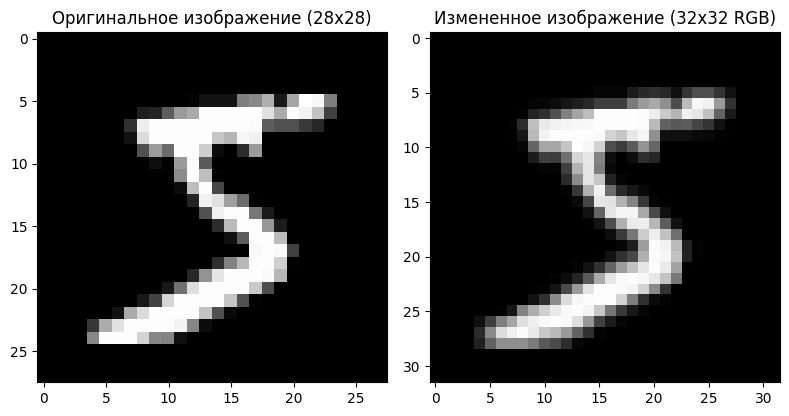

In [ ]:
# Увеличиваем разрешение до 32x32px

x_train_resized = tf.image.resize(np.expand_dims(x_train, axis=-1), [32, 32]).numpy() # по умолчанию билинейная интерполяция
x_test_resized = tf.image.resize(np.expand_dims(x_test, axis=-1), [32, 32]).numpy()
#x_train_resized = tf.image.resize(np.expand_dims(x_train, axis=-1), [32, 32], method='bicubic').numpy() #бикубическая

x_train_rgb = np.repeat(x_train_resized, 3, axis=-1)
x_test_rgb = np.repeat(x_test_resized, 3, axis=-1)

# Проверим новые размеры
print(f"Новый размер тренировочного набора: {x_train_rgb.shape}")
print(f"Новый размер тестового набора: {x_test_rgb.shape}")

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(x_train[0], cmap='gray')
plt.title("Оригинальное изображение (28x28)")
plt.subplot(1, 2, 2)
plt.imshow(x_train_rgb[0].astype(np.uint8))
plt.title("Измененное изображение (32x32 RGB)")

plt.tight_layout()
plt.show()

Результат не радует - изменилась структура пикселей объекта (класс 1). Здесь он белого цвета. А для решения конечной задачи измерения расстояния между границами объекта - это неприемлемо. Ведь теперь расстояние между граничными пикселями искажено.

Но есть и другой способ получить нужное разрешение, когда на снимках есть однородный фон. Мы можем просто физически нарастить изображения пикселями. В данном случае надо с каждой стороны добавить по 2 ряда пикселей.

Для задачи сегментации обычно требуется меньше изображений, чем, например, для задачи классификации (хотя сем.сегментация - та же классификация, только пикселей). Так что выделю из 70 тыс. датасета MNIST только 5 тыс. изображений. Больше просто colab не потянет, даже с GPU.

Размер изображений после padding: (5000, 32, 32)
Размер одного изображения после padding: (32, 32)
Сохранено 5000 изображений в /content/drive/MyDrive/Data_Mnist32_5


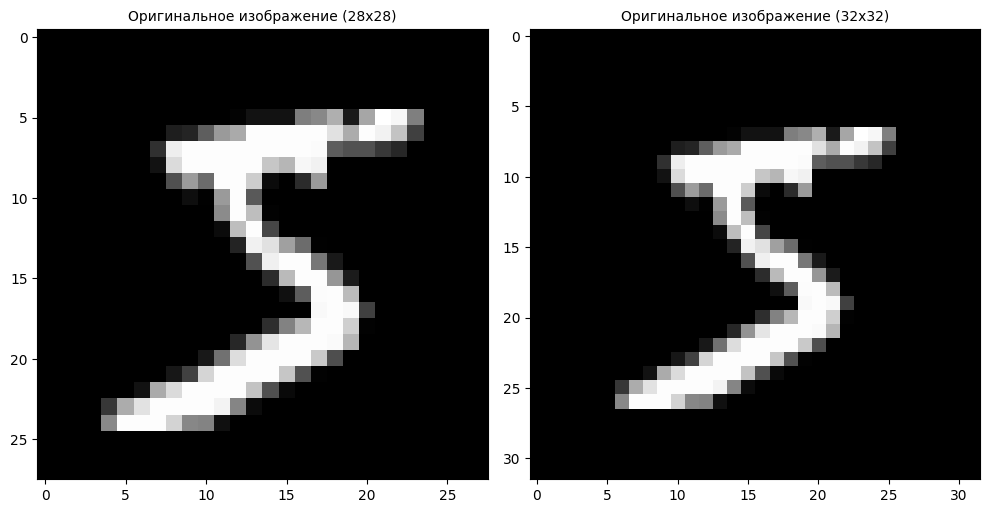

In [ ]:
# Загружаю данные MNIST и выделяю первые 5000 изображений

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:5000]
y_train = y_train[:5000]

# Добавляю черные пикселей по краям
def pad_image(img, pad_size=2):
  height, width = img.shape
  new_height = height + 2 * pad_size
  new_width = width + 2 * pad_size
  padded_img = np.zeros((new_height, new_width), dtype=img.dtype)  # Черный фон
  padded_img[pad_size:height+pad_size, pad_size:width+pad_size] = img  # Копирую исходное изображение в центр
  return padded_img

# Создаю копии
x_train_padded = np.array([pad_image(img) for img in x_train])

# Проверяю новый размер
print(f"Размер изображений после padding: {x_train_padded.shape}")
print(f"Размер одного изображения после padding: {x_train_padded[0].shape}")

# Создаю папку и сохраняю в нее новые изображения
output_dir = '/content/drive/MyDrive/Data_Mnist32_5'
os.makedirs(output_dir, exist_ok=True)

for i in range(x_train_padded.shape[0]):
    image = x_train_padded[i]
    image_path = os.path.join(output_dir, f"mnist_{i}.png")
    cv2.imwrite(image_path, image)

print(f"Сохранено {x_train_padded.shape[0]} изображений в {output_dir}")

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(x_train[0], cmap='gray')
plt.title(f"Оригинальное изображение (28x28)", fontsize=10)
plt.subplot(1, 2, 2)
plt.imshow(x_train_padded[0], cmap='gray')
plt.title("Оригинальное изображение (32x32)", fontsize=10)

plt.tight_layout()
plt.show()

Как видно, теперь структура пикселей осталась прежней, а пространственное разрешение изменилось до 32х32px.



In [ ]:
# Снова делаю маски для всех 5000 изображений и сохраняю в папки

from PIL import Image

input_dir = "/content/drive/MyDrive/Data_Mnist32_5"

output_images_dir = "/content/drive/MyDrive/Data/imagess32_5"
output_masks_dir = "/content/drive/MyDrive/Data/maskss32_5"

# Порог для создания маски
threshold = 30

os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_masks_dir, exist_ok=True)

image_files = sorted(os.listdir(input_dir))

# Обрабатываем первые 5000 файлов
for i, filename in enumerate(image_files[:5000]):
    input_path = os.path.join(input_dir, filename)

    image = Image.open(input_path).convert('L')
    x_train_padded = np.array(image)

    masks = (x_train_padded > 30).astype(np.uint8)

    # Сохраняем изображение
    output_image_path = os.path.join(output_images_dir, f"mnist_{i}.png")
    image.save(output_image_path)

    # Сохраняем маску
    output_mask_path = os.path.join(output_masks_dir, f"mask_{i}.png")
    mask_image = Image.fromarray(masks.squeeze().astype(np.uint8) * 255)
    mask_image.save(output_mask_path)

print("Сохранение завершено")

Сохранение завершено


Теперь, казалось бы, можно подавать датасет на обучение в нейросеть.

Однако лучше сначала убедиться, что нет дисбаланса классов. Это один из факторов, который оказывает существенное влияние на результат.

Раз семантическая сегментация это классификация пикселей, то подсчитаем баланс по двум классам - для черных и белых пикселей в масках у всего датасета.

In [ ]:
# подсчет количества пикселей датасета по классу объект и фон (белые и черные пиксели)

from PIL import Image

def analyze_mask_dataset(mask_dir):
    """
    Анализирует датасет масок, подсчитывая общее количество пикселей,
    а также процент белых и черных пикселей.

    Args:
        mask_dir (str): Путь к директории с масками.

    Returns:
        tuple: Общее количество пикселей, процент белых пикселей, процент черных пикселей.
    """
    total_pixels = 0
    white_pixels = 0

    for filename in os.listdir(mask_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(mask_dir, filename)
            try:
                img = Image.open(filepath)
                img_array = np.array(img)

                # Преобразуем в одноканальное изображение, если оно многоканальное
                if len(img_array.shape) > 2:
                    img_array = img_array[:, :, 0]

                # Подсчитываем количество белых и общее количество пикселей
                total_pixels += img_array.size
                white_pixels += np.sum(img_array == 255)

            except Exception as e:
                print(f"Ошибка при обработке файла {filename}: {e}")
                continue

    if total_pixels == 0:
        return 0, 0, 0

    white_percentage = (white_pixels / total_pixels) * 100
    black_percentage = 100 - white_percentage

    return total_pixels, white_percentage, black_percentage

mask_directory = '/content/drive/MyDrive/Data/maskss32_5'

total_pixels, white_percentage, black_percentage = analyze_mask_dataset(mask_directory)

print(f"Общее количество пикселей в датасете: {total_pixels}")
print(f"Процент белых пикселей: {white_percentage:.2f}%")
print(f"Процент черных пикселей: {black_percentage:.2f}%")

Общее количество пикселей в датасете: 5120000
Процент белых пикселей: 13.09%
Процент черных пикселей: 86.91%


Видим, что дисбаланс присутствует, и довольно серьезный. Так что это **третья проблема** в процессе эксперимента (первая и  вторая проблемы, напоминаю, - были связаны с градиентом и интерполяцией).

Часто дисбаланс классов преодолевают путем аугументации, но в случае семантической сегментации это бессмысленно, ведь увеличится количество пикселей для обоих классов.

Есть другой способ - применить **принцип взвешивания классов**, присвоив каждому классу веса, пропорциональные его доле в данных. Соответственно, тому классу, где меньше количество пикселей, присвоятся более высокие веса, чтобы модель при обучении уделяла ему больше внимания. Эту функцию встроим в модель нейросетки. И увидим, что веса были определены как:

Веса классов: {0: 0.5755723497441401, 1: 3.8080882207104465}

Заранее скажу, что этого все равно оказалось мало для получения нужного - близкого к идеальному - результата.

Запустим нейросетку на 20 эпох - этого достаточно, чтобы решить, успешен эксперимент или нет.

В дополнение применим небольшую аугументацию, в основном, связанную с изменением визуального представления изображения: контраст, яркость, гистограммы и пр.

In [ ]:
IMAGE_SIZE = (32, 32)
NUM_CLASSES = 2           # для бинарной сегментации (объект и фон)
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
EPOCHS = 20
DATASET_DIR = '/content/drive/MyDrive/Data'

# Ставим метрику iou -----------------------------------------------------------
def mean_iou(num_classes):
    def mean_iou_metric(y_true, y_pred):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.cast(y_true, tf.int64)

        iou = []
        for i in range(num_classes):
            intersection = tf.reduce_sum(tf.cast((y_true == i) & (y_pred == i), tf.float32))
            union = tf.reduce_sum(tf.cast((y_true == i) | (y_pred == i), tf.float32))
            iou.append(intersection / (union + tf.keras.backend.epsilon()))

        return tf.reduce_mean(iou)

    return mean_iou_metric


# Ставим метрики P и R ---------------------------------------------------------
def multiclass_precision(num_classes):
    def precision(y_true, y_pred):
        y_pred = tf.argmax(y_pred, axis=-1)  # Преобразуем предсказания в метки
        y_true = tf.cast(y_true, tf.int64)

        precisions = []
        for i in range(num_classes):
            true_positive = tf.reduce_sum(tf.cast((y_true == i) & (y_pred == i), tf.float32))
            predicted_positive = tf.reduce_sum(tf.cast(y_pred == i, tf.float32))
            precisions.append(true_positive / (predicted_positive + tf.keras.backend.epsilon()))

        return tf.reduce_mean(precisions)  # Усредняем по всем классам
    return precision

def multiclass_recall(num_classes):
    def recall(y_true, y_pred):
        y_pred = tf.argmax(y_pred, axis=-1)  # Преобразуем предсказания в метки
        y_true = tf.cast(y_true, tf.int64)

        recalls = []
        for i in range(num_classes):
            true_positive = tf.reduce_sum(tf.cast((y_true == i) & (y_pred == i), tf.float32))
            actual_positive = tf.reduce_sum(tf.cast(y_true == i, tf.float32))
            recalls.append(true_positive / (actual_positive + tf.keras.backend.epsilon()))

        return tf.reduce_mean(recalls)  # Усредняем по всем классам
    return recall


# Определяем пайплайн аугментации ----------------------------------------------
def get_augmentation_pipeline():
    return A.Compose(
        [
            A.RandomBrightnessContrast(p=0.8),
            A.CLAHE(clip_limit=2, p=0.3),
            A.Sharpen(p=0.3),
            A.Emboss(p=0.3),
        ]
    )

# Функция для применения аугментации
def augment_image_and_mask(image, mask, augmentation_pipeline):
    augmented = augmentation_pipeline(image=image, mask=mask)
    return augmented['image'], augmented['mask']

# Функция для применения аугментации в формате tf.data.Dataset
def augment_data(image, mask, should_augment):
    # Преобразуем тензоры в numpy для работы с Albumentations
    image, mask = image.numpy(), mask.numpy()

    if should_augment:
        # Применяем аугментацию
        augmented_image, augmented_mask = augment_image_and_mask(image, mask, augmentation_pipeline)
    else:
        augmented_image, augmented_mask = image, mask

    # Преобразуем обратно в тензоры
    return tf.convert_to_tensor(augmented_image, dtype=tf.float32), tf.convert_to_tensor(augmented_mask, dtype=tf.int32)

    augmented_image, augmented_mask = tf.py_function(
        func=lambda image, mask, should_augment: augment_data(image, mask, should_augment),
        inp=[image, mask, should_augment],
        Tout=[tf.float32, tf.int32]
    )
    augmented_image.set_shape(IMAGE_SIZE + (3,))
    augmented_mask.set_shape(IMAGE_SIZE)
    return augmented_image, augmented_mask

# Получаем пайплайн аугментации
augmentation_pipeline = get_augmentation_pipeline()

# Ф-я препроцессинга - размер, нормализация ------------------------------------
def preprocess_data(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    label = tf.image.resize(label, IMAGE_SIZE, method='nearest')  # Надо 'nearest' для меток

    # Преобразовать метки в целые числа
    label = tf.cast(label, tf.int32)

    # Нормализовать метки до 0 и 1
    label = tf.where(label == 255, 1, 0)

    # Удалить последнее измерение, если оно существует
    label = tf.squeeze(label, axis=-1)

    return image / 255.0, label

# Создать tf.data.Dataset из списков файлов ------------------------------------
def create_dataset(image_files, mask_files):
    def load_data(image_path, mask_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)

        return image, mask

    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(load_data)
    return dataset

def prepare_data(image, mask, mask_file_name):
    image, mask = preprocess_data(image, mask)
    #image, mask = tf_augment_data(image, mask, mask_file_name)
    return image, mask

train_image_files = sorted(glob(os.path.join(DATASET_DIR, "imagess32_3", "*.png")))
train_mask_files = sorted(glob(os.path.join(DATASET_DIR, "maskss32_3", "*.png")))
val_image_files = sorted(glob(os.path.join(DATASET_DIR, "imagess32_3", "*.png")))
val_mask_files = sorted(glob(os.path.join(DATASET_DIR, "maskss32_3", "*.png")))

train_dataset = create_dataset(train_image_files, train_mask_files)
val_dataset = create_dataset(val_image_files, val_mask_files)

# Получаем имена файлов масок
def get_mask_file_name(image, mask, mask_file):
    return mask_file

def map_prepare_data(image, mask, mask_file):
    image, mask = prepare_data(image, mask, mask_file)
    return image, mask

# Добавляем имена файлов масок в датасет
def add_mask_filename(image, mask, mask_file):
    return image, mask, tf.convert_to_tensor(os.path.basename(mask_file), dtype=tf.string)

train_dataset = train_dataset.map(lambda image, mask, mask_file=train_mask_files[0]: add_mask_filename(image, mask, mask_file))
val_dataset = val_dataset.map(lambda image, mask, mask_file=val_mask_files[0]: add_mask_filename(image, mask, mask_file))

# Применяем предобработку и выборочную аугментацию
train_dataset = train_dataset.map(lambda image, mask, mask_file: map_prepare_data(image, mask, mask_file))
val_dataset = val_dataset.map(lambda image, mask, mask_file: map_prepare_data(image, mask, mask_file))

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Архитектура модели + взвешивание классов

from tensorflow.keras.applications import ResNet101
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight  # Для взвешивания классов

# Функция для получения меток из tf.data.Dataset
def get_labels_from_dataset(dataset):
    all_labels = []
    for _, labels in dataset:
        if len(labels.shape) == 4:
            labels = tf.squeeze(labels, axis=-1)
        all_labels.append(labels.numpy().flatten())
    return np.concatenate(all_labels, axis=0)

# Получаем метки из обучающего датасета
train_labels = get_labels_from_dataset(train_dataset)

# Вычисляем веса классов
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(train_labels),
                                                  y=train_labels)
class_weight_dict = dict(zip(np.unique(train_labels), class_weights))
print("Веса классов:", class_weight_dict)

# Преобразуем веса в тензор (нужно для TensorFlow)
class_weights_tensor = tf.constant(class_weights, dtype=tf.float32) # Явно указываем тип данных

# Загружаем предобученную базовую модель ResNet101
def create_deeplabv3plus(input_shape, num_classes):
    base_model = ResNet101(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Замораживаем веса базовой модели

    # Вытаскиваем нужные слои из ResNet101
    layer_names = ["conv4_block22_out", "conv2_block2_out"]  # Высоко- и низкоуровневые признаки
    layers_dict = {layer.name: layer for layer in base_model.layers}

    # Проверка существования слоев. Важно, так как имена могут отличаться
    if layer_names[0] not in layers_dict or layer_names[1] not in layers_dict:
        raise ValueError(f"Один или оба слоя '{layer_names[0]}' и '{layer_names[1]}' не найдены в ResNet101. Проверьте имена слоев.")

    high_level_features = layers_dict[layer_names[0]].output
    low_level_features = layers_dict[layer_names[1]].output

    # Обработка низкоуровневых признаков
    low_level_features = layers.Conv2D(48, (1, 1), padding="same", activation="relu")(low_level_features)
    low_level_features = layers.BatchNormalization()(low_level_features)

    # Обработка высокоуровневых признаков
    high_level_features = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(high_level_features)
    high_level_features = layers.BatchNormalization()(high_level_features)

    # Объединяем признаки
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(high_level_features)
    x = layers.Concatenate()([x, low_level_features])
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    # Финальный слой
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(x)

    return Model(inputs=base_model.input, outputs=outputs)

# Создаем модель ---------------------------------------------------------------
model = create_deeplabv3plus(input_shape=IMAGE_SIZE + (3,), num_classes=NUM_CLASSES)
model.summary()

# Компиляция модели
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=SparseCategoricalCrossentropy(from_logits=False, # не надо from_logits=False, т.к. у нас softmax
                                       reduction=tf.keras.losses.Reduction.NONE), # Важно для sample_weight
    metrics=[
        "accuracy",
        mean_iou(num_classes=NUM_CLASSES),
        multiclass_precision(num_classes=NUM_CLASSES),
        multiclass_recall(num_classes=NUM_CLASSES)
  ]
)

class BalancedPrecisionRecallCallback(tf.keras.callbacks.Callback):
    def __init__(self, filepath, threshold=1.1):
        super().__init__()
        self.filepath = filepath
        self.threshold = threshold
        self.best_score = -float('inf')   # Лучший результат по Precision и Recall
        self.best_f1 = -float('inf')      # Лучший F1-score

    def on_epoch_end(self, epoch, logs=None):
        # Получаем значения Precision и Recall из логов
        precision = logs.get("val_precision")  # Используем правильное имя метрики
        recall = logs.get("val_recall")        # Используем правильное имя метрики

        # Проверяем, что метрики существуют
        if precision is None or recall is None:
            print(f"\n[Ошибка] Метрики Precision или Recall отсутствуют в логах. Проверьте их наличие в model.compile().")
            return

        # Рассчитываем соотношение Precision и Recall
        ratio = max(precision / recall, recall / precision)  # Берем максимальное отношение

        # Если Precision и Recall сбалансированы (соотношение <= threshold)
        if ratio <= self.threshold:
            # Рассчитываем среднее значение Precision и Recall
            score = (precision + recall) / 2

            # Сохраняем модель, если среднее значение лучше предыдущего
            if score > self.best_score:
                self.best_score = score
                self.model.save(self.filepath)
                self.best_f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())  # Обновляем F1-score
                print(f"\n[Сохранение модели] Эпоха {epoch + 1}: Precision: {precision:.4f}, Recall: {recall:.4f}, Ratio: {ratio:.4f}, F1: {self.best_f1:.4f}")
        else:
            # Если Precision и Recall не сбалансированы, проверяем F1-score
            f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
            if f1 > self.best_f1:
                self.best_f1 = f1
                filepath_f1 = self.filepath.replace(".keras", "_f1.keras")  # Сохраняем модель с новым именем
                self.model.save(filepath_f1)
                print(f"\n[Сохранение модели по F1] Эпоха {epoch + 1}: F1 улучшился до {f1:.4f}")
            else:
                print(f"\n[Пропуск сохранения] Эпоха {epoch + 1}: Precision: {precision:.4f}, Recall: {recall:.4f}, Ratio: {ratio:.4f}, F1: {f1:.4f}")

# ВАЖНО: Функция для применения весов к каждому примеру (изображению)
def apply_class_weights(image, mask):
    # mask имеет размерность (height, width) - индексы классов
    sample_weights = tf.gather(class_weights_tensor, tf.cast(mask, tf.int32))  # Получаем веса для каждого пикселя
    return image, mask, sample_weights  # Возвращаем изображение, маску и веса

# Применяем веса к обучающей выборке
train_dataset = train_dataset.map(apply_class_weights)

# Параметры
filepath = "best_balanced_model_ResNet101.keras"
threshold = 1.1  # Максимальное отклонение Precision от Recall (например, 10%)

# Создаем экземпляр кастомного колбэка
balanced_callback = BalancedPrecisionRecallCallback(filepath=filepath, threshold=threshold)

# Обучение модели
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[balanced_callback]  # Передаем колбэк
)

# Сохраняем модель
model.save("deeplabv3plus_ResNet101.keras")

# Сохраняем веса модели
model.save_weights("deeplabv3plus_ResNet101.weights.h5")

Веса классов: {0: 0.5755723497441401, 1: 3.8080882207104465}
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 29,613,170 (112.97 MB)

 Trainable params: 3,074,194 (11.73 MB)

 Non-trainable params: 26,538,976 (101.24 MB)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.7593 - loss: 0.4278 - mean_iou_metric: 0.5416 - precision: 0.6768 - recall: 0.8473
[Сохранение модели по F1] Эпоха 1: F1 улучшился до 0.6464
94/94 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.7598 - loss: 0.4271 - mean_iou_metric: 0.5421 - precision: 0.6771 - recall: 0.8477 - val_accuracy: 0.8703 - val_loss: 0.3312 - val_mean_iou_metric: 0.4414 - val_precision: 0.8934 - val_recall: 0.5063
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.8662 - loss: 0.2759 - mean_iou_metric: 0.6712 - precision: 0.7484 - recall: 0.9218
[Сохранение модели] Эпоха 2: Precision: 0.8343, Recall: 0.8627, Ratio: 1.0340, F1: 0.8483
94/94 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.8663 - loss: 0.2758 - mean_iou_metric: 0.6714 - precision: 0.7485 - recall: 0.9218 - val_accuracy: 0.9277 - val_loss: 0.3129 - val_mean_iou_metric: 0.7518 - val_precision: 0.8343 - val_recall: 0.8627
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms

P.S. Это был не первый запуск модели, в итоге на этот раз память исчерпалась на 6 эпохах. Так что пришлось прерваться. А графики и метрики приведены относительно одного из прежних запусков

**Для 5 тыс и 20 эпох**

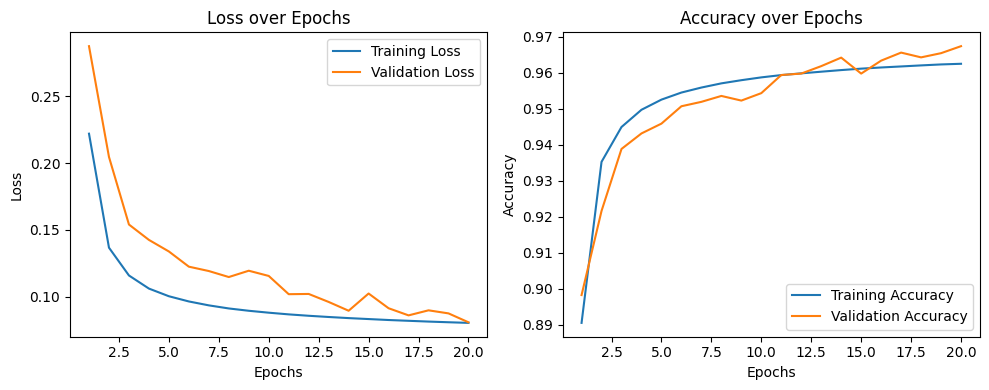

In [ ]:
import matplotlib.pyplot as plt

# Извлекаем данные из объекта history
epochs = range(1, len(history.history['loss']) + 1)  # Номера эпох
loss = history.history['loss']  # Потери на обучении
val_loss = history.history['val_loss']  # Потери на валидации
accuracy = history.history['accuracy']  # Точность на обучении
val_accuracy = history.history['val_accuracy']  # Точность на валидации
mean_iou = history.history.get('mean_iou_metric', None)  # IoU на обучении (если есть)
val_mean_iou = history.history.get('val_mean_iou_metric', None)  # IoU на валидации (если есть)


# Построение графиков
plt.figure(figsize=(10, 4))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
'''
Считаем метрики и получаем неплохой результат:

Mean Precision: 0.9286
Mean Recall: 0.9686
Class 0: Precision = 0.9934, Recall = 0.9667
Class 1: Precision = 0.8639, Recall = 0.9705
'''

def calculate_metrics(model, dataset, num_classes):
    """
    Вычисляет Precision и Recall для всего датасета, исключая маски, содержащие только пиксели класса 0.

    model: обученная модель
    dataset: tf.data.Dataset (валидационный или тестовый набор)
    num_classes: количество классов
    """
    y_true_all = []
    y_pred_all = []

    # Проходим по всему датасету
    for images, labels in dataset:
        # Получаем предсказания
        predictions = model.predict(images)
        predictions = tf.argmax(predictions, axis=-1)  # Преобразуем в метки классов

        # Убираем лишнее измерение у меток, если оно есть
        if len(labels.shape) == 4:  # Если метки имеют размерность [batch_size, height, width, 1]
            labels = tf.squeeze(labels, axis=-1)  # Убираем последнее измерение

        # Исключаем маски, содержащие только пиксели класса 0
        for label, prediction in zip(labels.numpy(), predictions.numpy()):
            if np.any(label):  # Если хотя бы один пиксель не равен 0
                y_true_all.append(label.flatten())
                y_pred_all.append(prediction.flatten())

    # Преобразуем списки в массивы
    if y_true_all and y_pred_all:  # Проверяем, что есть данные для расчёта
        y_true_all = np.concatenate(y_true_all, axis=0)
        y_pred_all = np.concatenate(y_pred_all, axis=0)
    else:
        raise ValueError("Все маски содержат только пиксели класса 0. Невозможно вычислить метрики.")

    # Вычисляем Precision и Recall для каждого класса
    precisions = []
    recalls = []
    for i in range(num_classes):
        tp = np.sum((y_true_all == i) & (y_pred_all == i))  # True Positives
        fp = np.sum((y_true_all != i) & (y_pred_all == i))  # False Positives
        fn = np.sum((y_true_all == i) & (y_pred_all != i))  # False Negatives

        precision = tp / (tp + fp + 1e-7)  # Добавляем 1e-7, чтобы избежать деления на 0
        recall = tp / (tp + fn + 1e-7)

        precisions.append(precision)
        recalls.append(recall)

    # Усредняем Precision и Recall по всем классам
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)

    return mean_precision, mean_recall, precisions, recalls

# Пример вызова функции
mean_precision, mean_recall, precisions, recalls = calculate_metrics(model, val_dataset, NUM_CLASSES)

print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
for i, (p, r) in enumerate(zip(precisions, recalls)):
    print(f"Class {i}: Precision = {p:.4f}, Recall = {r:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


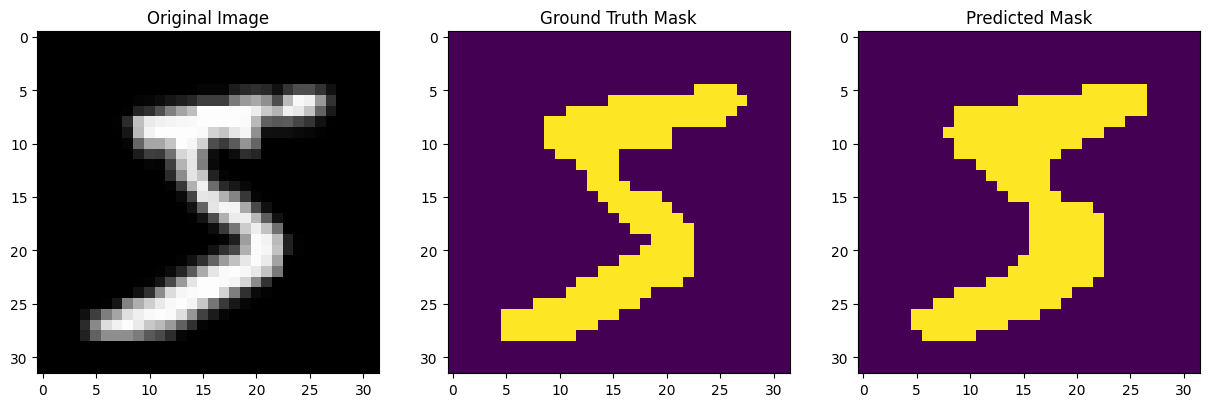

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


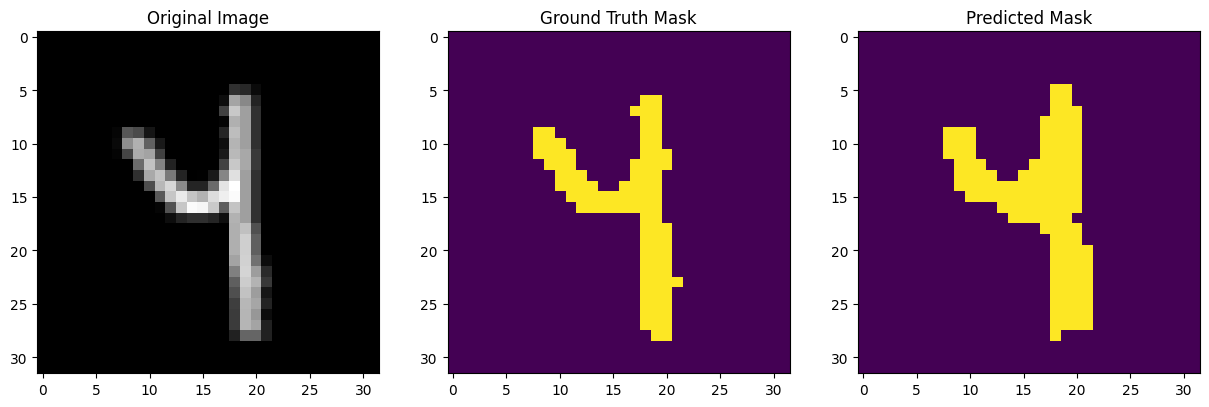

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


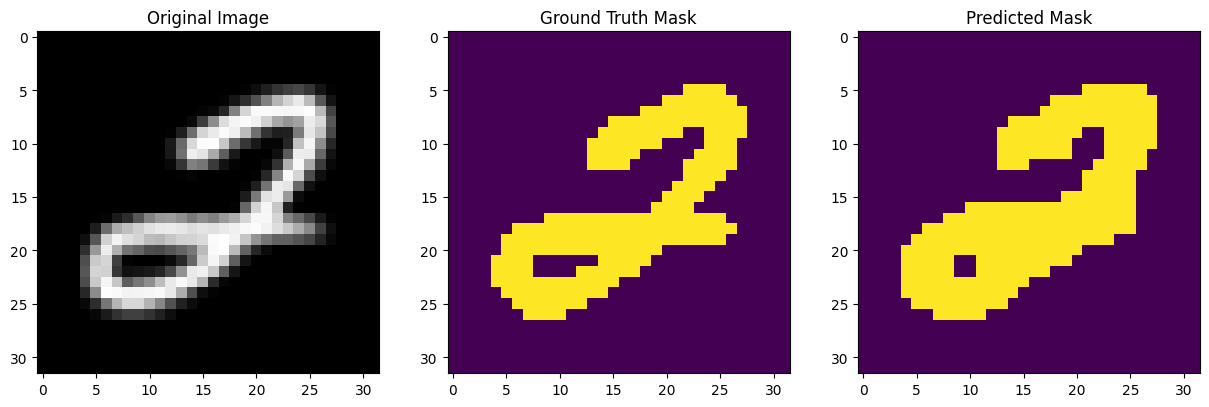

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


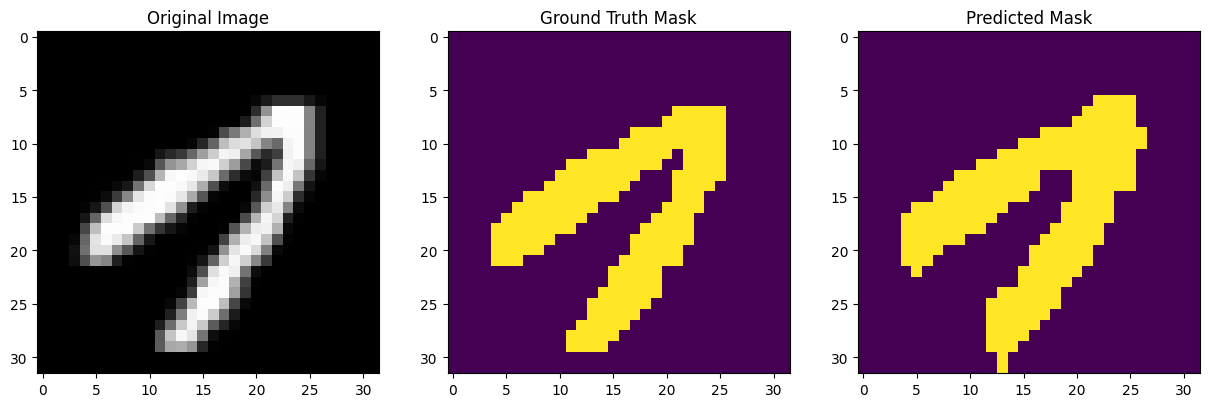

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


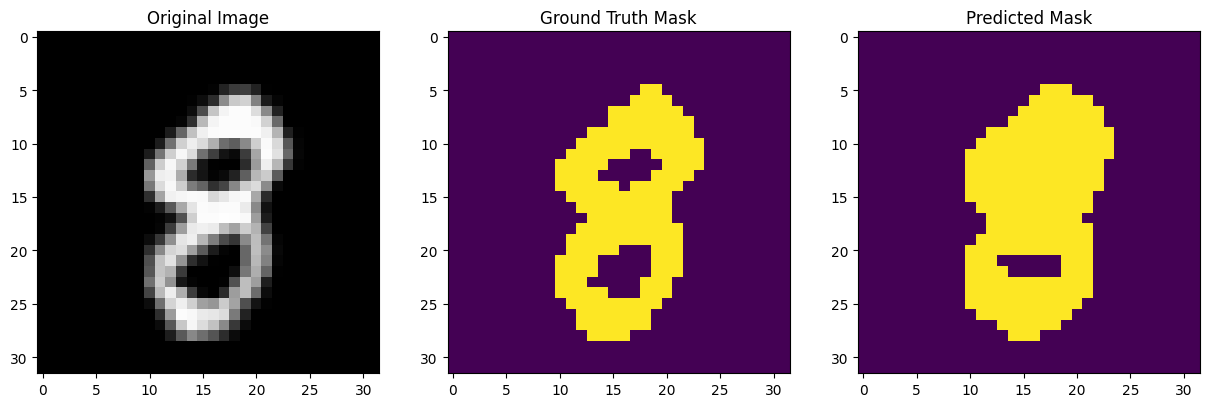

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


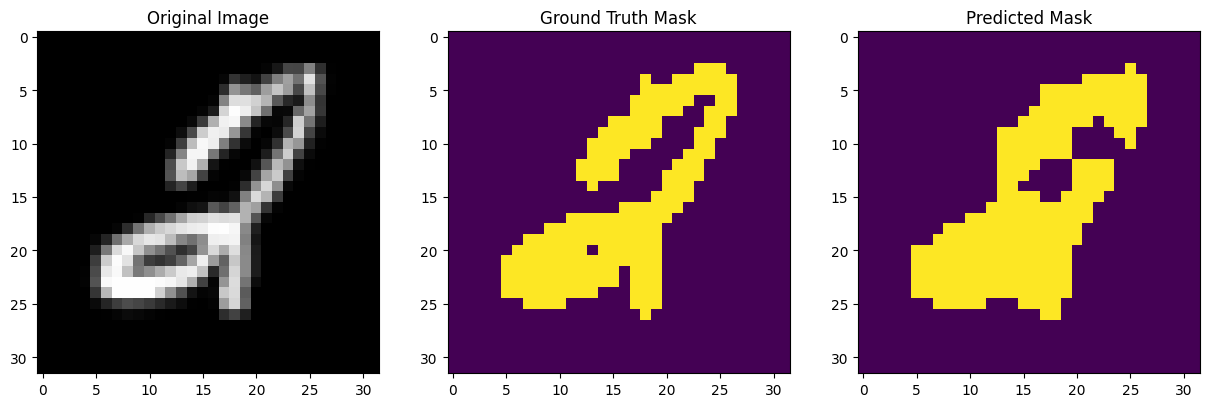

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


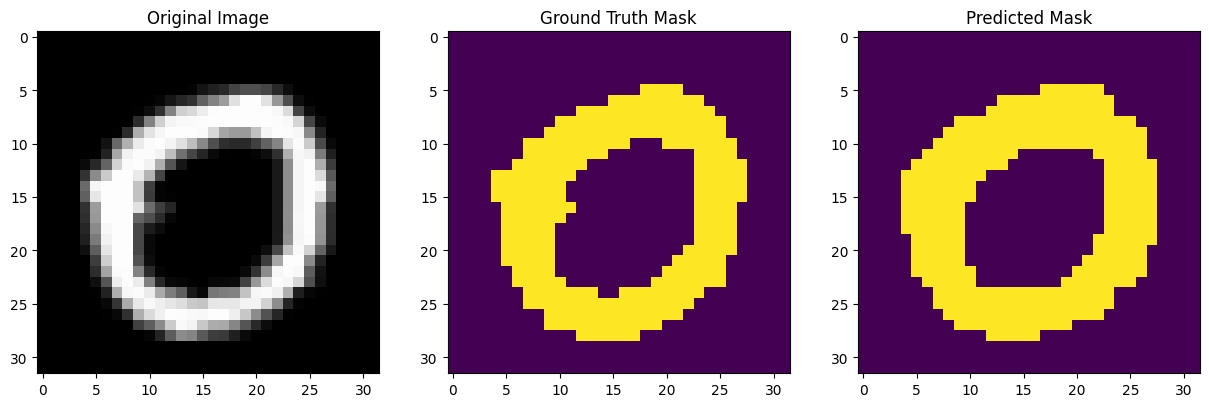

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


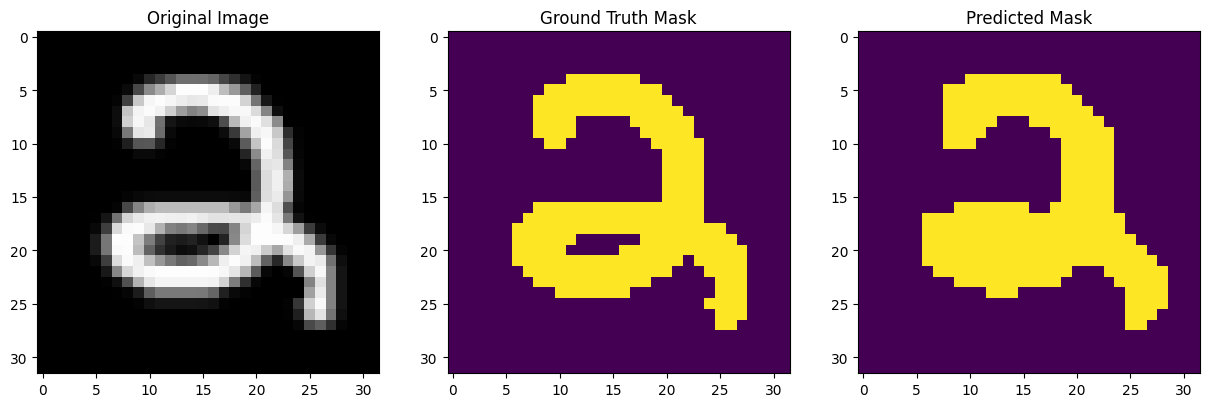

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


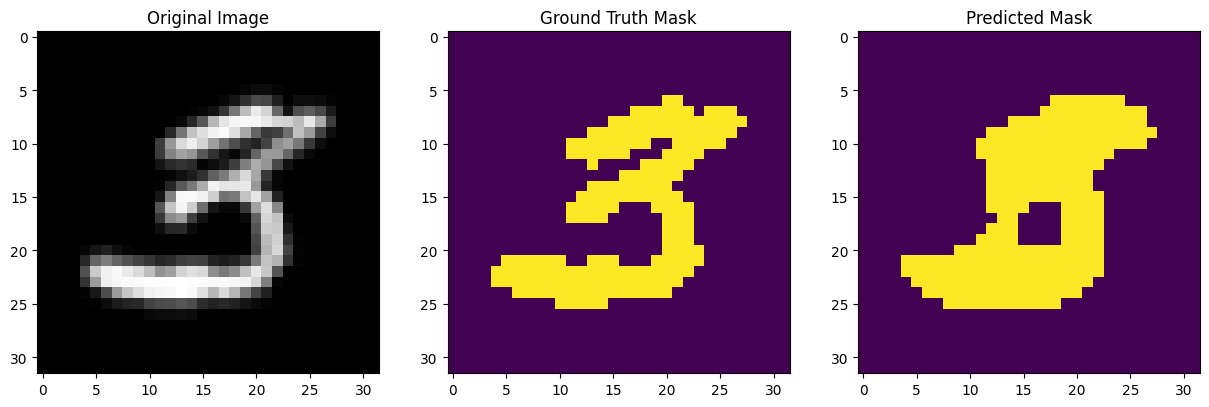

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


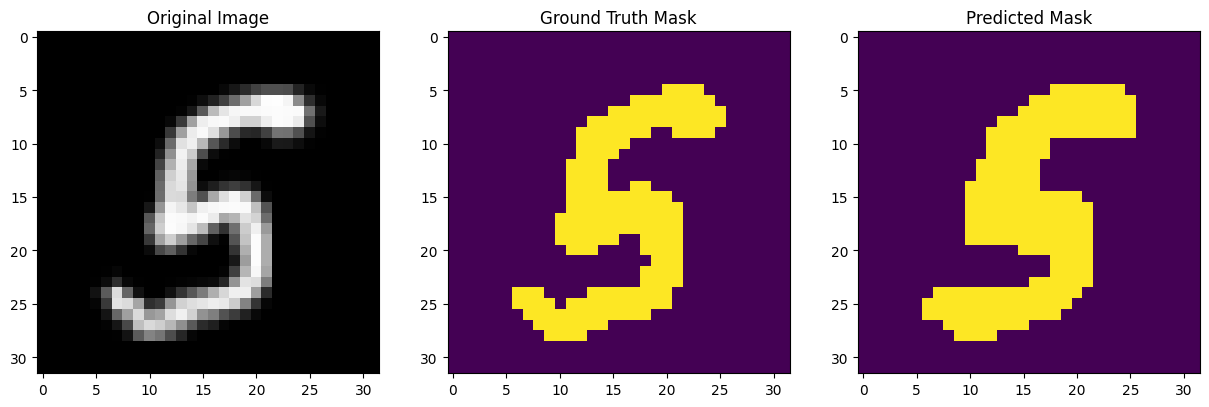

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


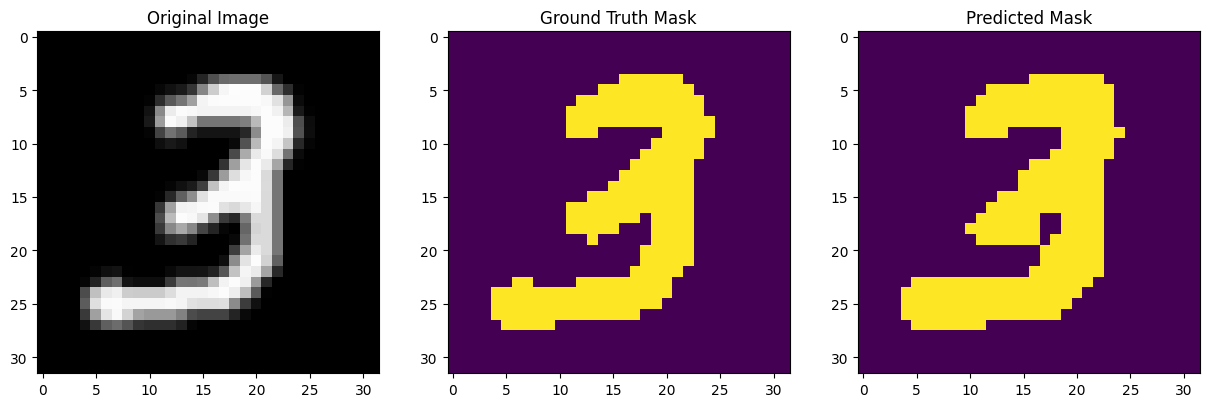

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


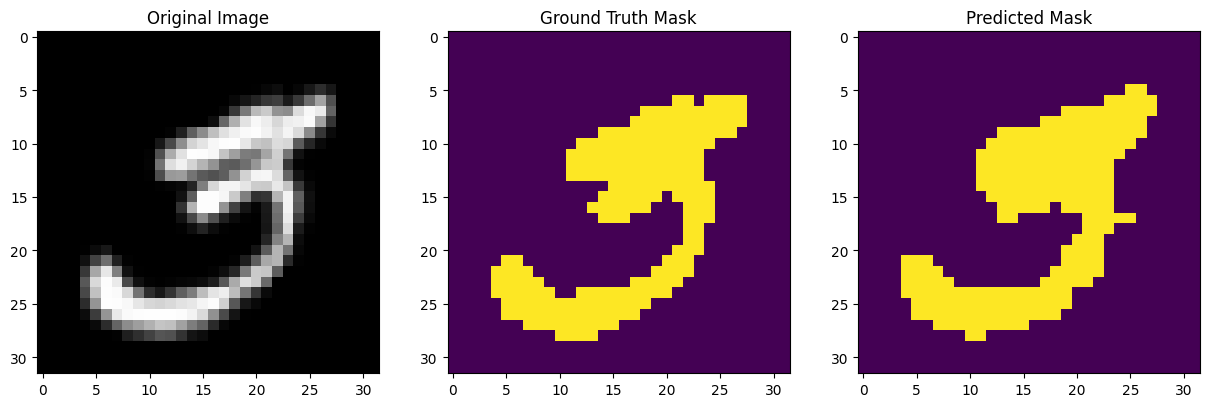

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


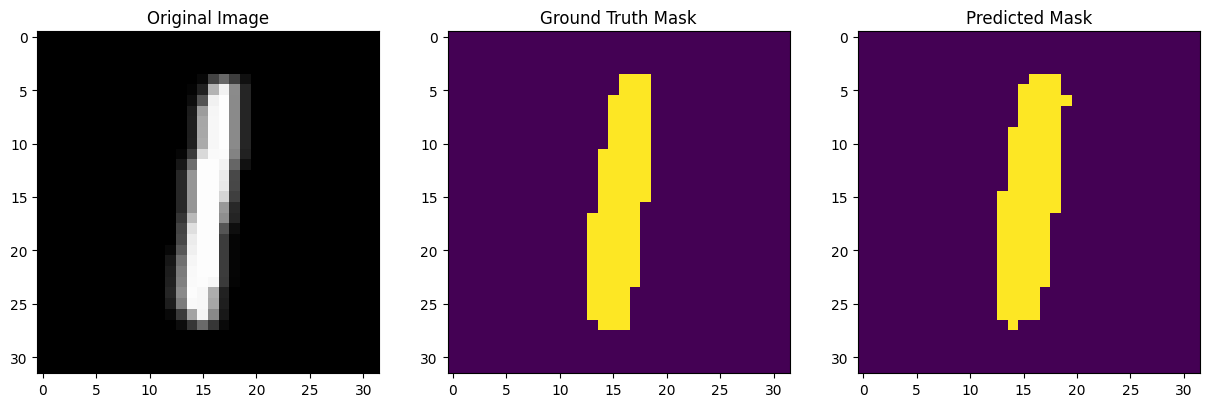

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


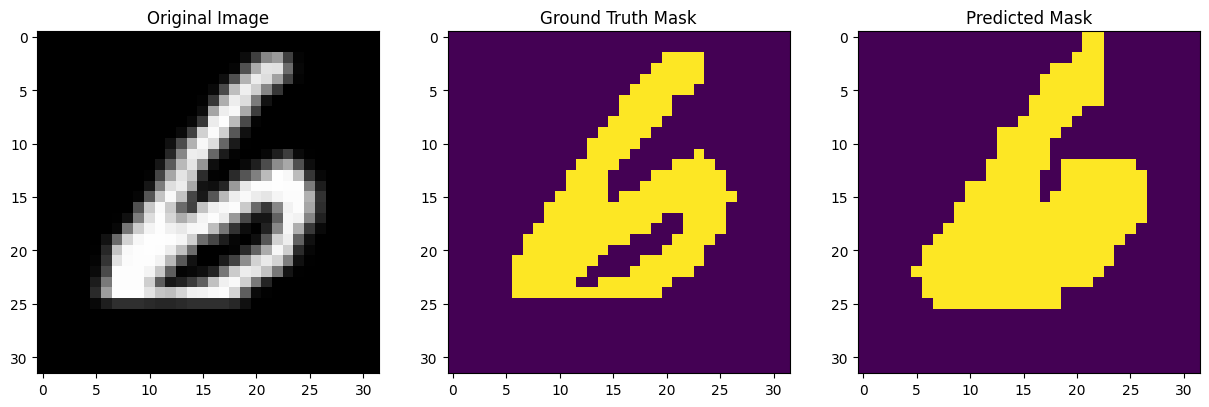

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


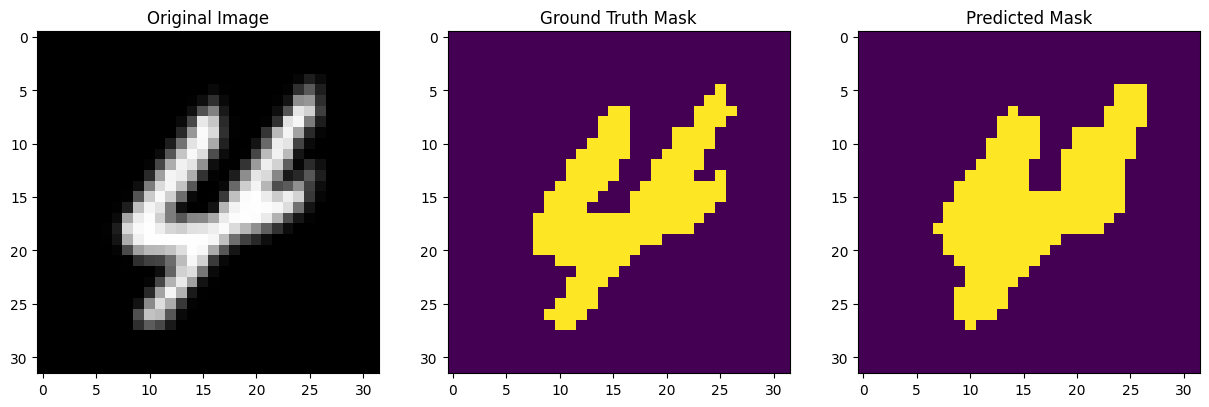

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


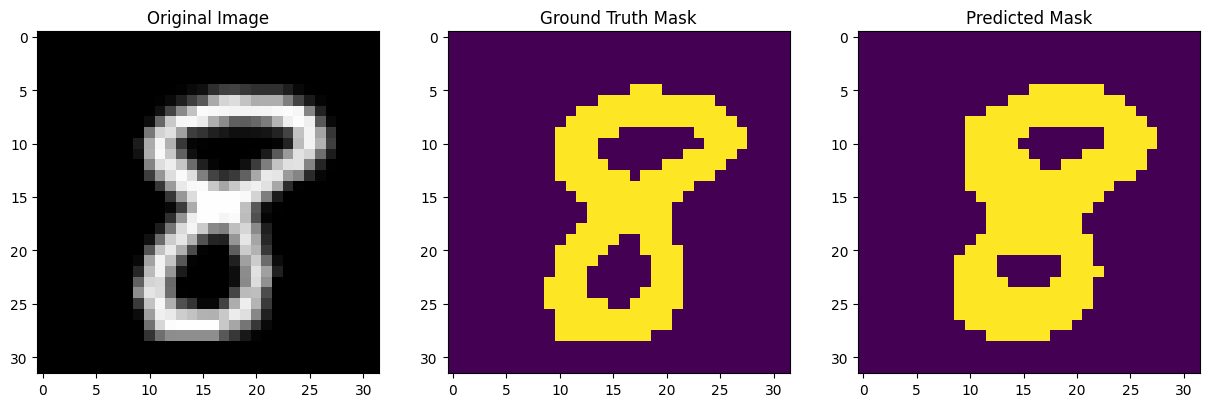

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


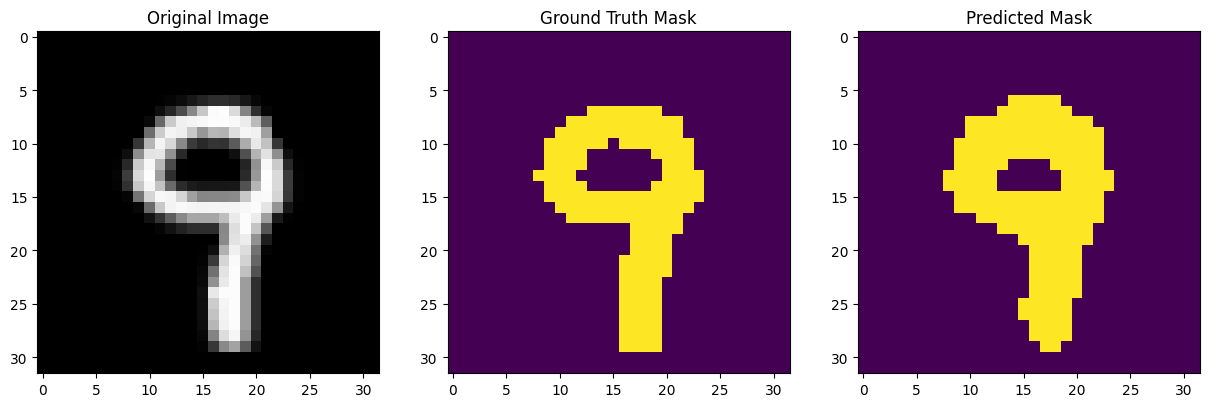

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


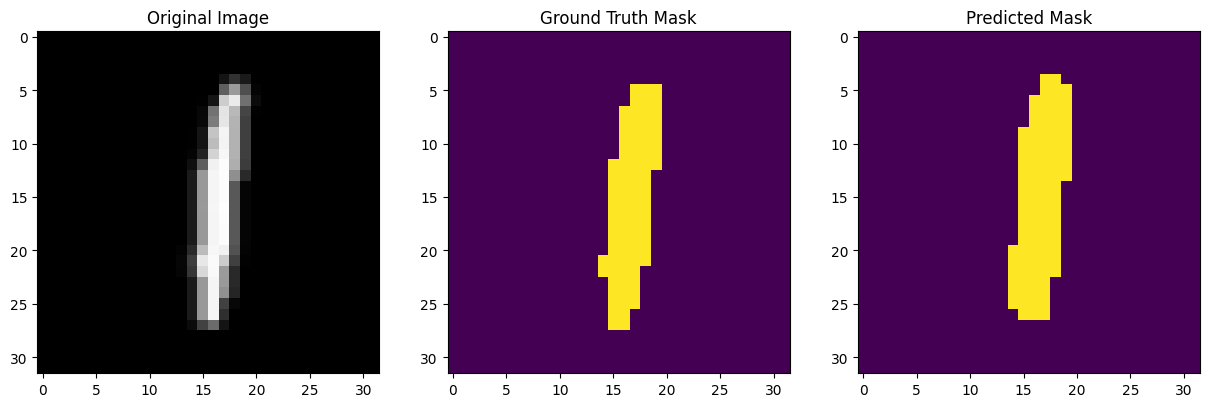

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


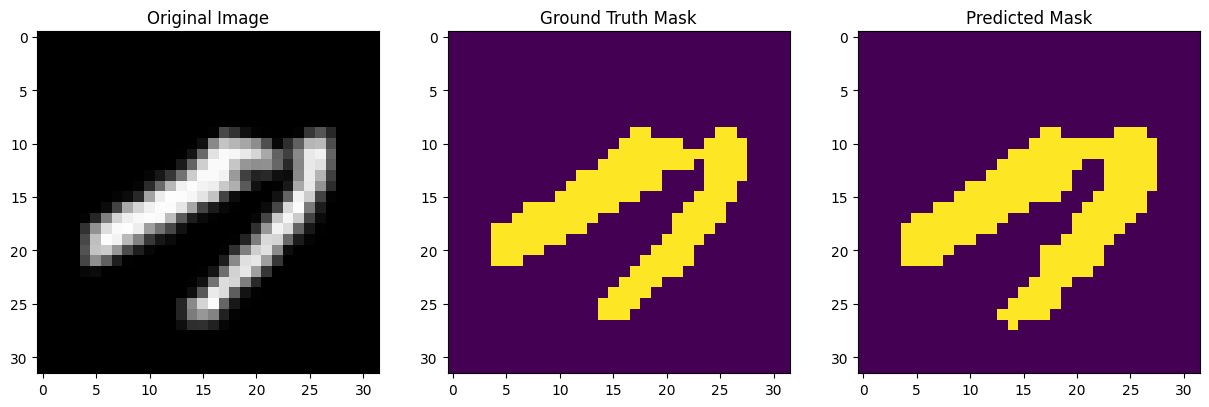

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


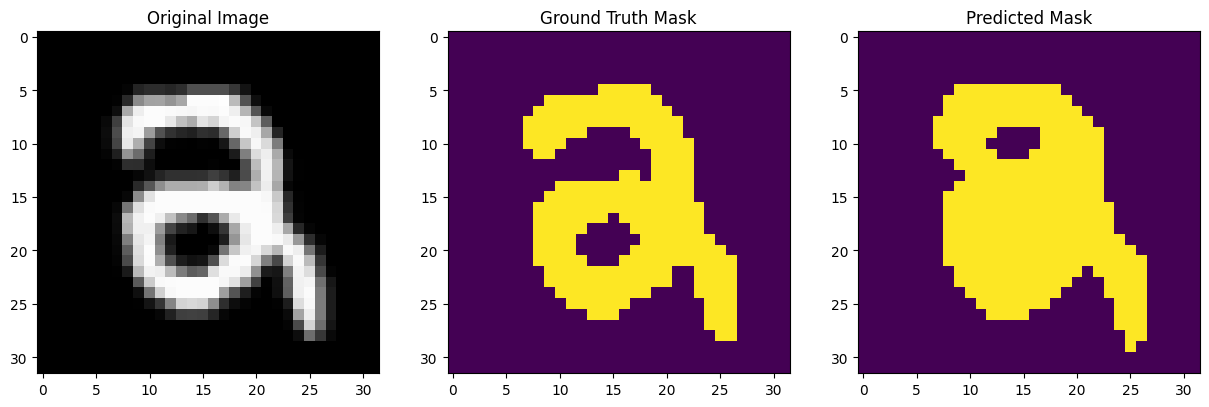

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


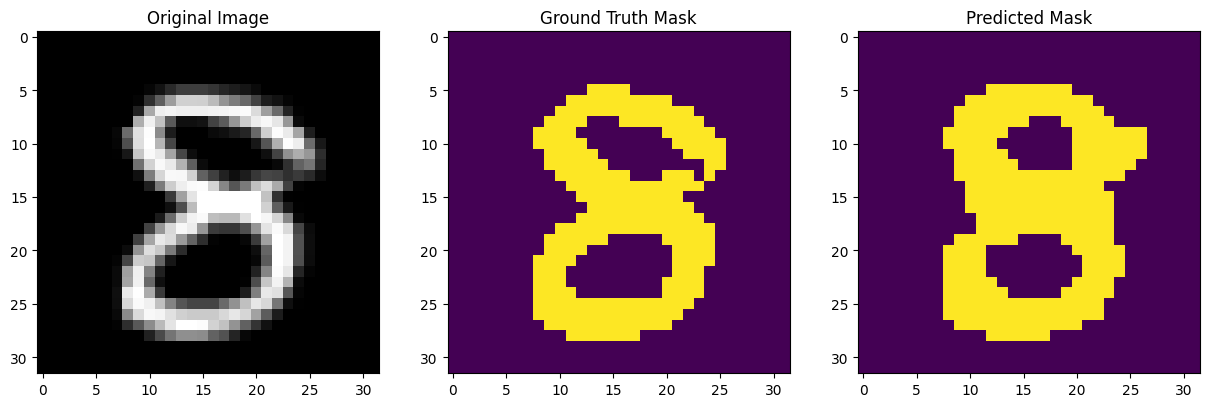

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


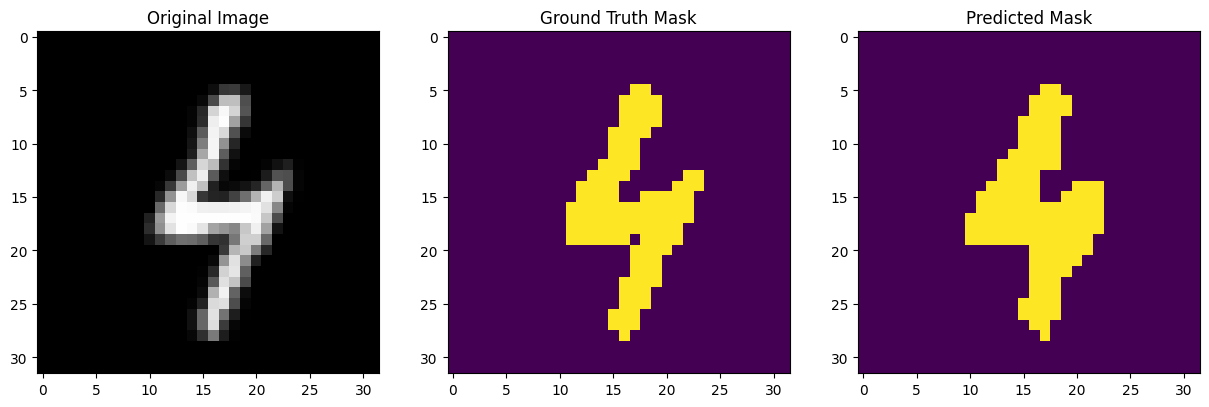

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


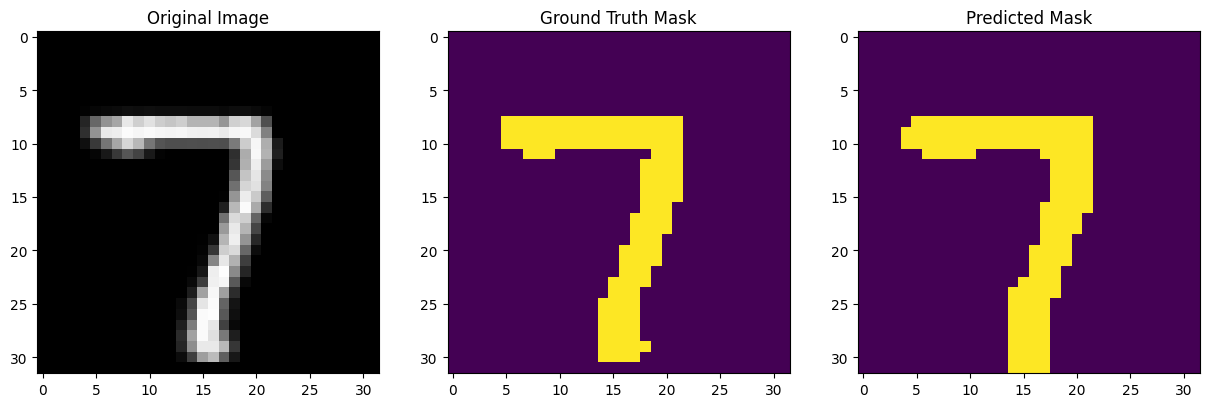

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


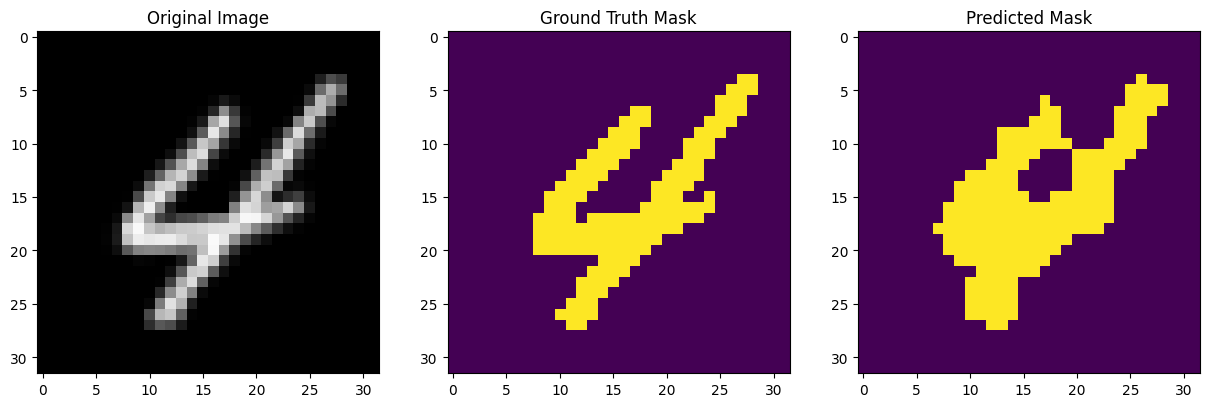

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


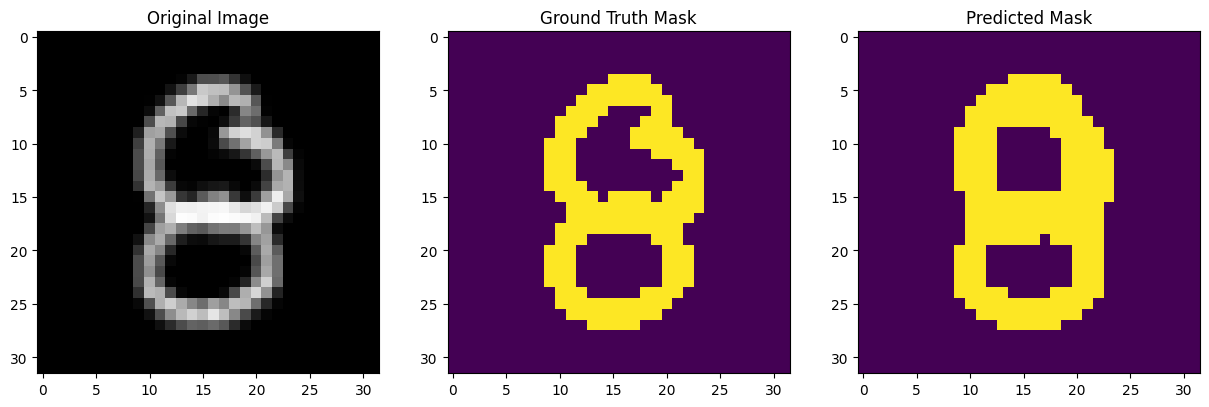

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


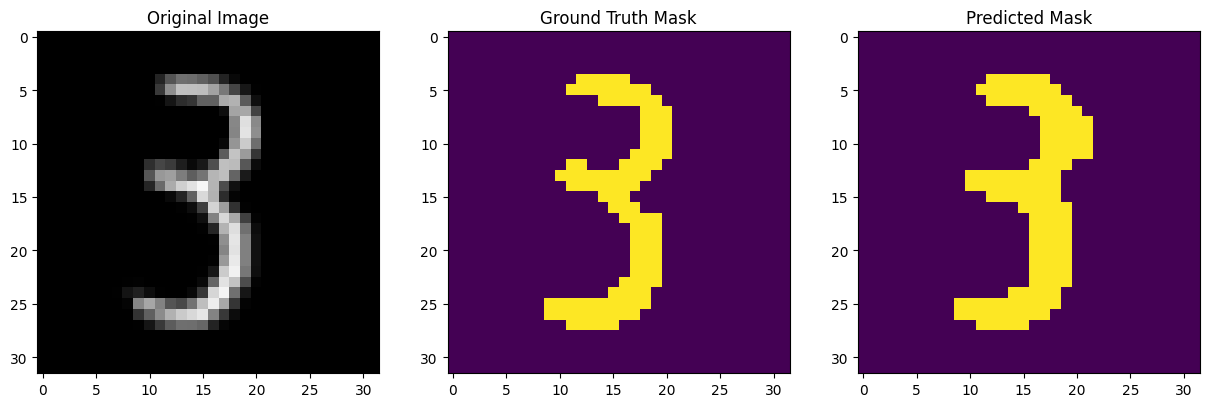

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


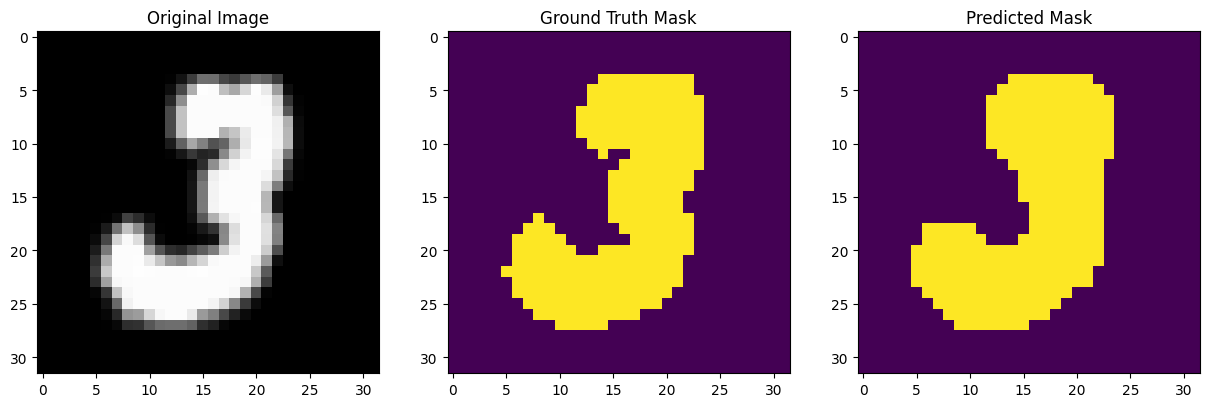

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


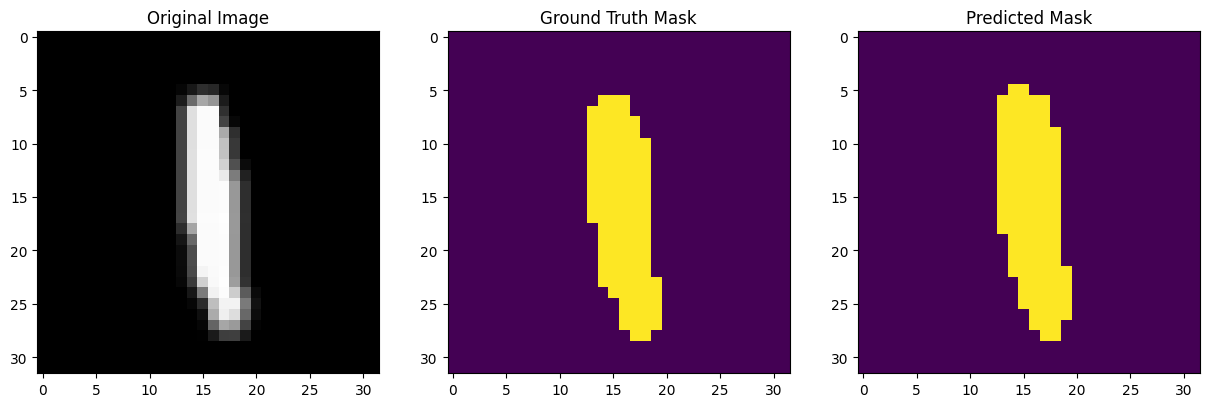

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


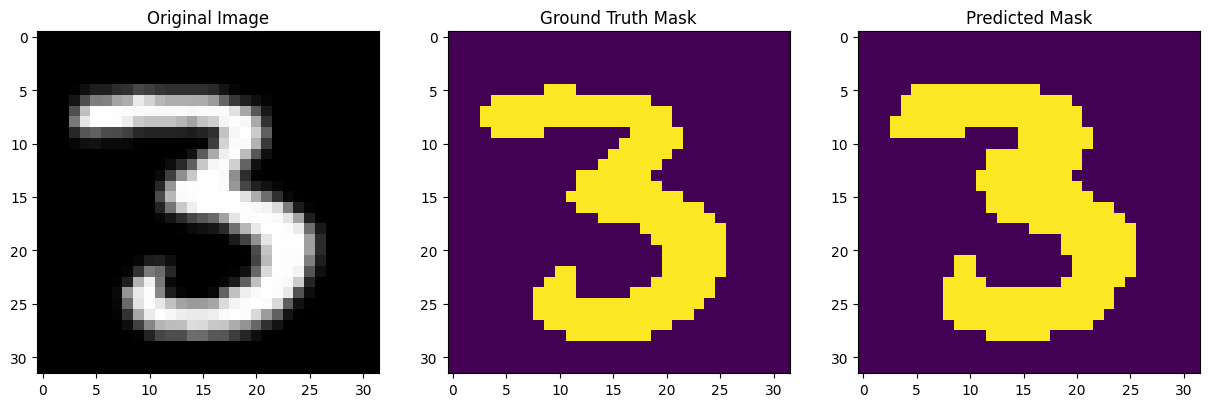

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


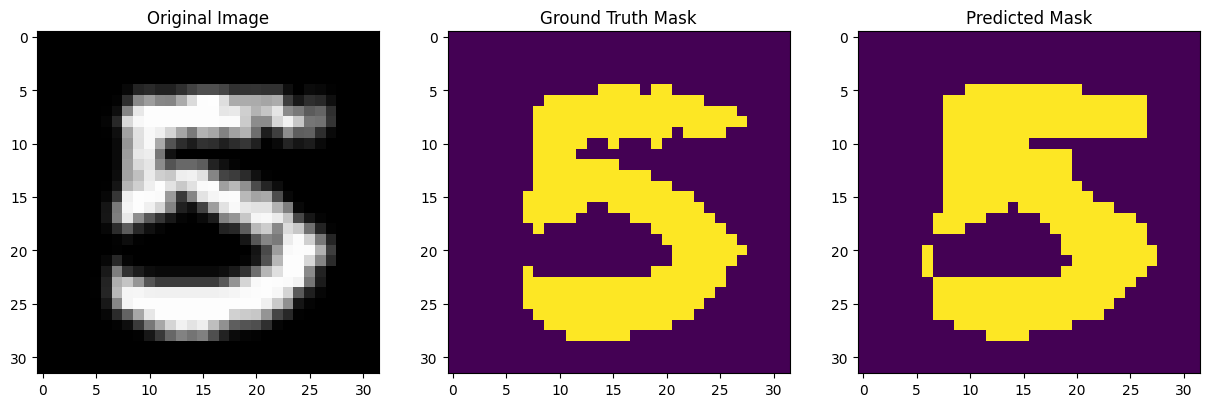

In [ ]:
# Визуализируем предсказанные маски для тестового набора


def visualize_predictions(model, dataset, num_samples=3):
    """
    Визуализирует оригинальные изображения, истинные маски и предсказанные маски.

    model: обученная модель
    dataset: tf.data.Dataset (валидационный или тестовый набор)
    num_samples: количество изображений для визуализации
    """
    # Получаем батч данных из датасета
    dataset_iter = iter(dataset)

    for i in range(num_samples):
        # Извлекаем изображения и метки из датасета
        images, true_masks = next(dataset_iter)

        # Делаем предсказания
        predictions = model.predict(images)
        predicted_masks = tf.argmax(predictions, axis=-1)  # Преобразуем в метки классов

        # Визуализируем результаты
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        # Оригинальное изображение
        ax[0].imshow((images[0].numpy() * 255).astype("uint8"))
        ax[0].set_title("Original Image")

        # Истинная маска
        ax[1].imshow(true_masks[0].numpy(), cmap="viridis")  # Отображаем маску
        ax[1].set_title("Ground Truth Mask")

        # Предсказанная маска
        ax[2].imshow(predicted_masks[0].numpy(), cmap="viridis")  # Отображаем предсказанную маску
        ax[2].set_title("Predicted Mask")

        plt.show()

# Пример использования
visualize_predictions(model, val_dataset, num_samples=30)

Очевидно, чтот 20 эпох мало и 5 тыс экземпляров - тоже мало. А может, напротив, много. На то и эксперимент, чтобы запукать при разных условиях и параметрах.

Ниже приведены итоги запуска нейросеток с

- 3 тыс и 100 эпох
- 1 тыс и 50 эпох

Ну, так себе.

**Для 3 тыс и 100 эпох**

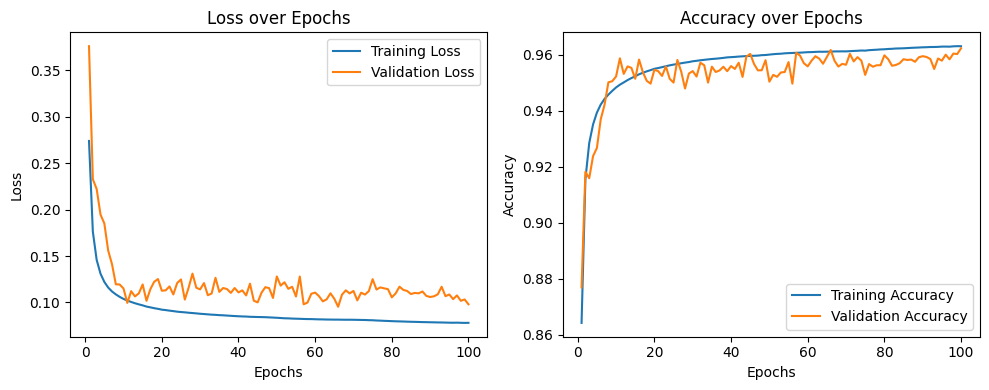

In [ ]:
# Accuracy и Loss

In [ ]:
# Метрики

Mean Precision: 0.8903
Mean Recall: 0.9736
Class 0: Precision = 0.9982, Recall = 0.9584
Class 1: Precision = 0.7823, Recall = 0.9888

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


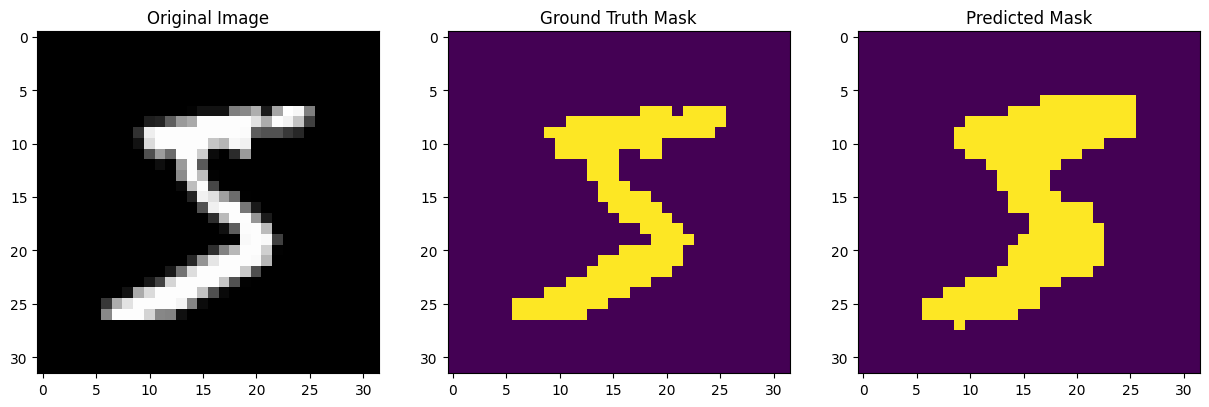

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


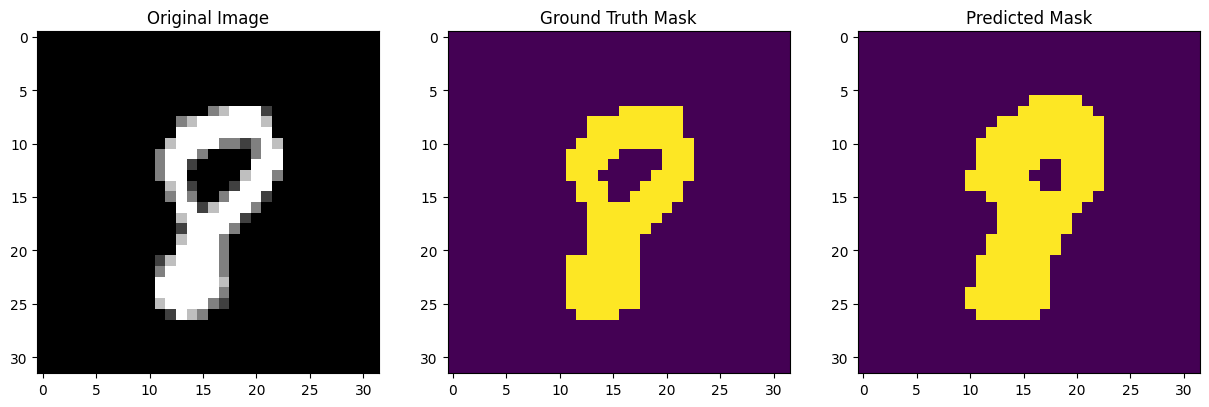

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


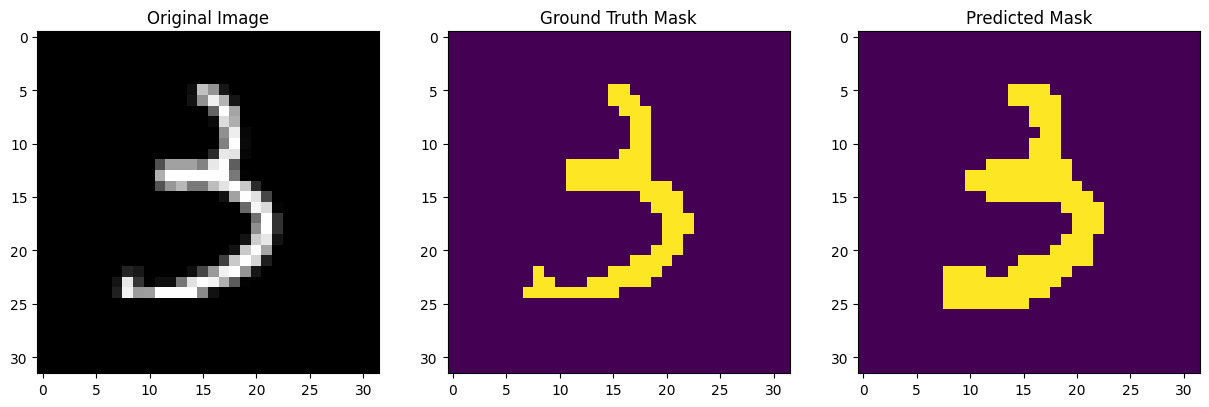

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


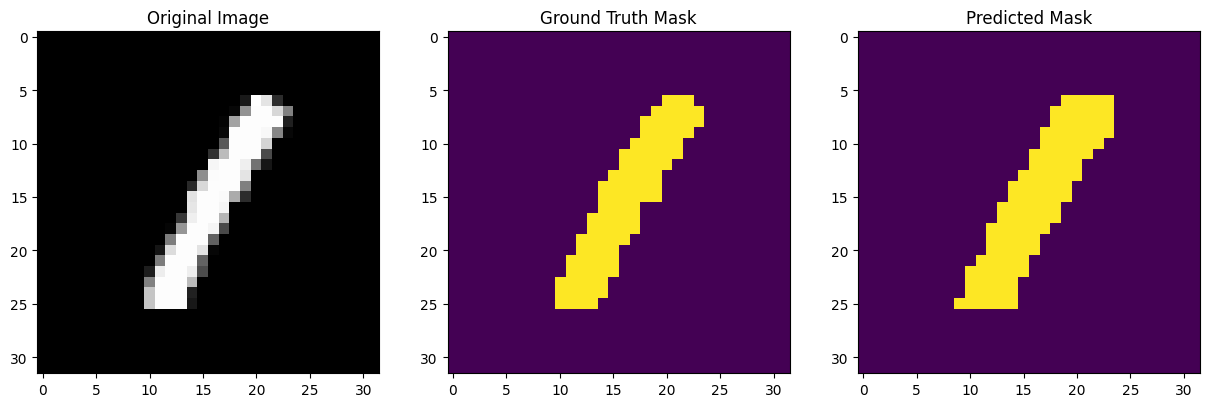

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


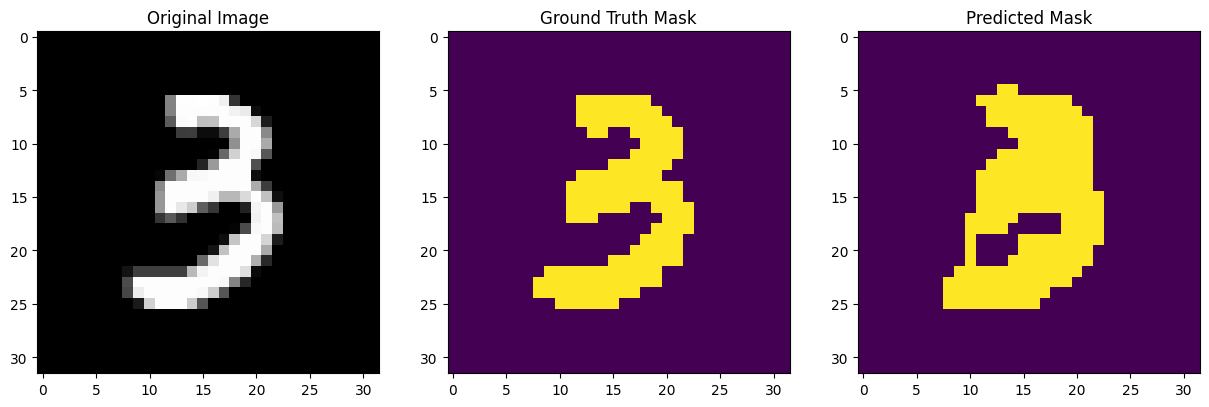

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


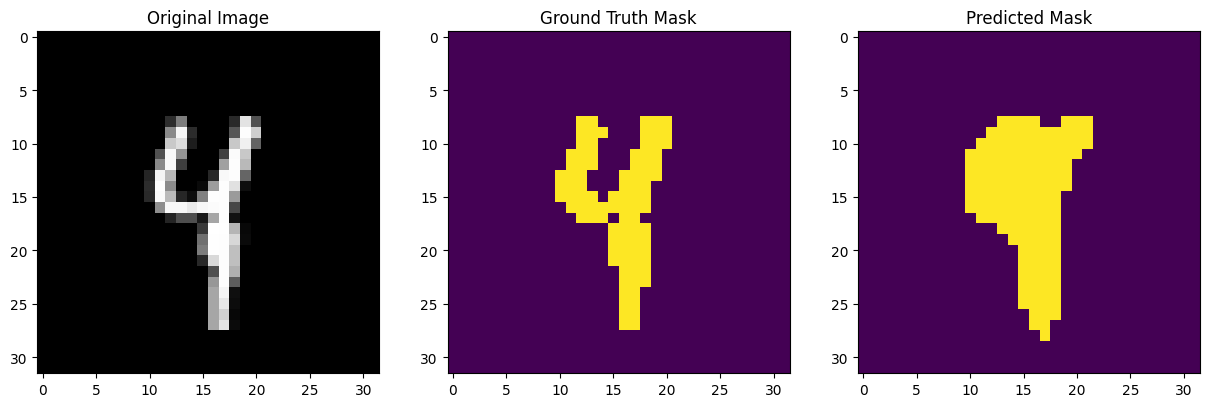

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


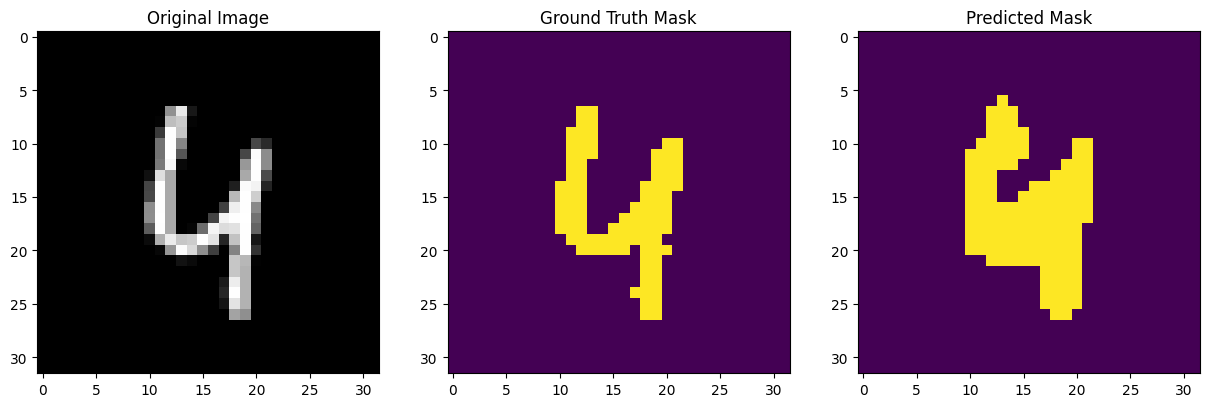

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


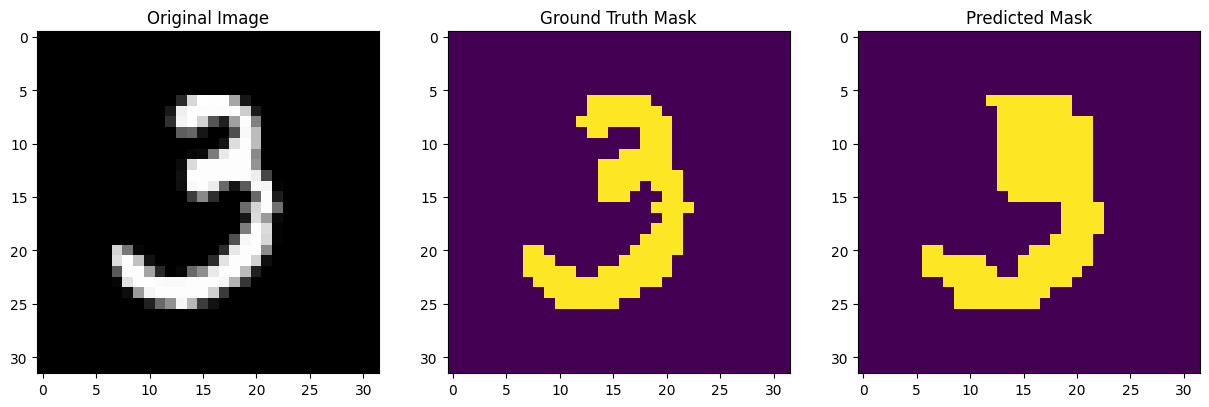

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


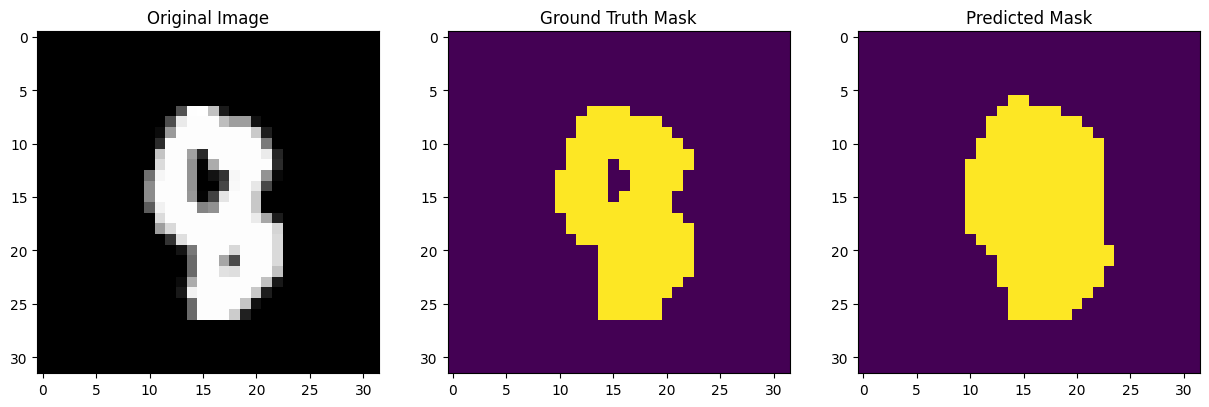

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


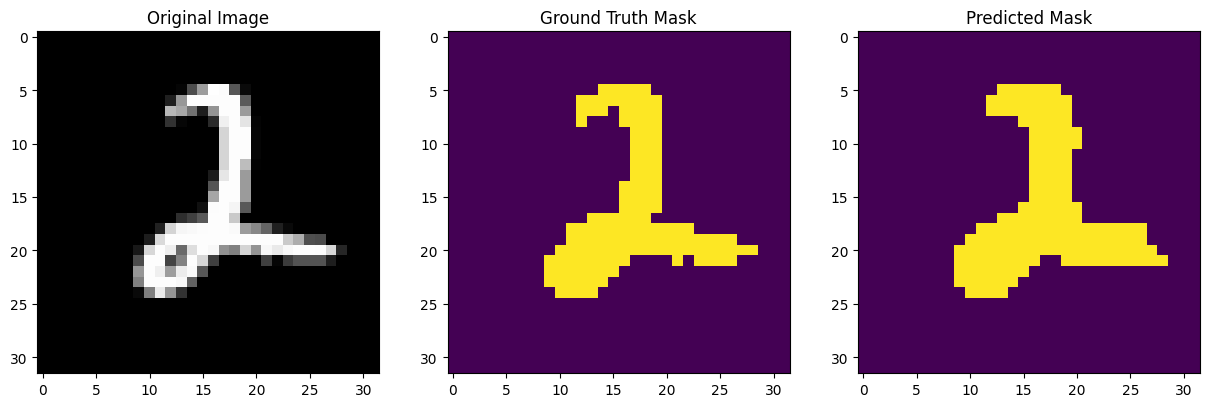

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


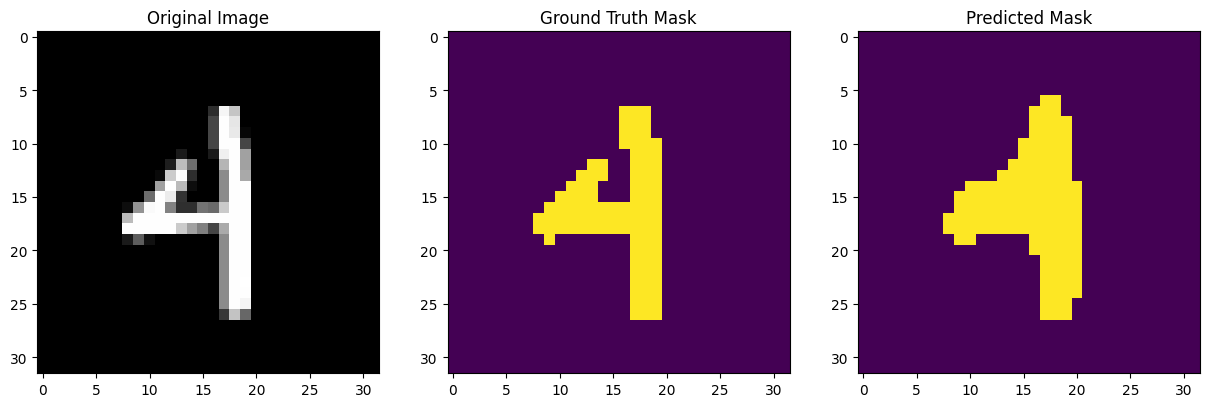

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


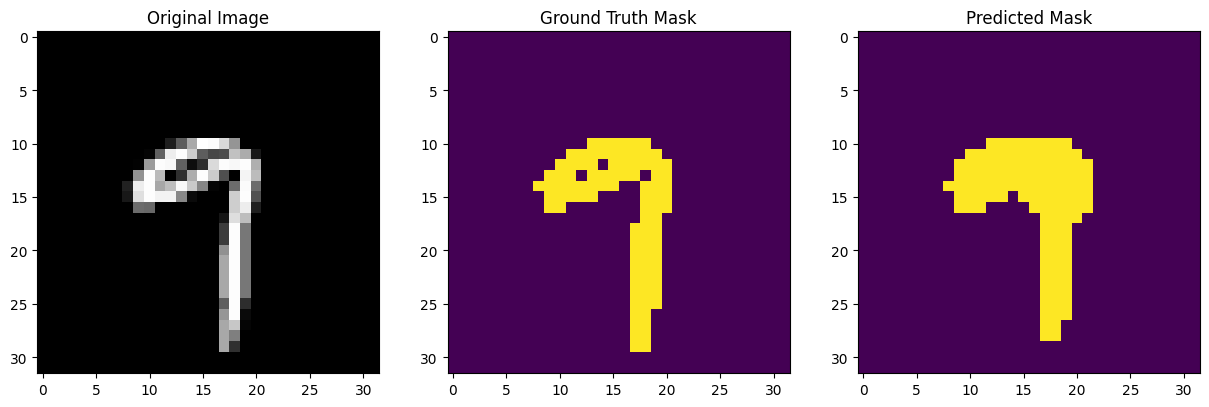

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


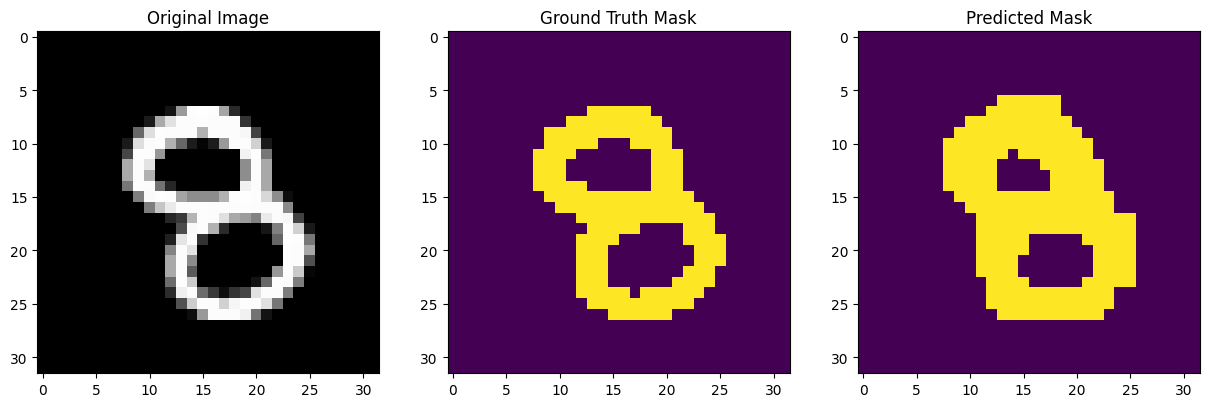

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


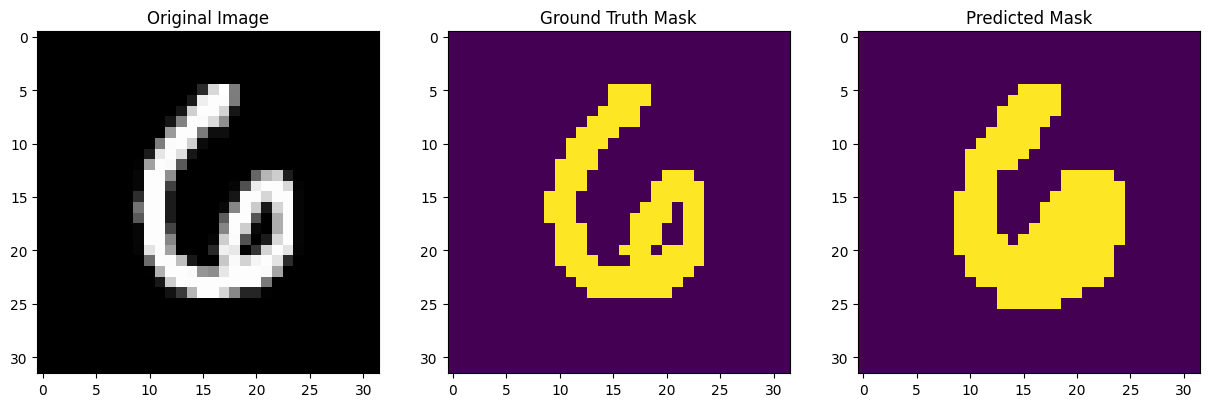

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


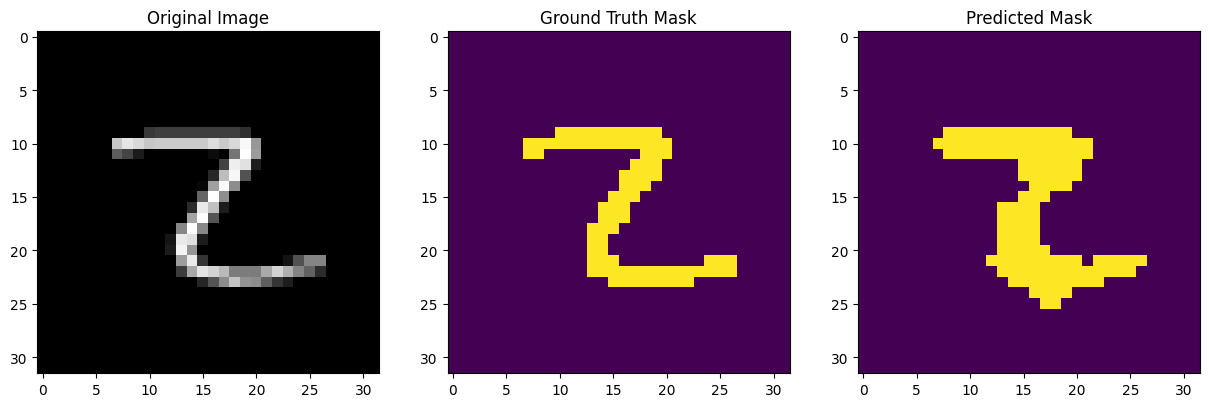

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


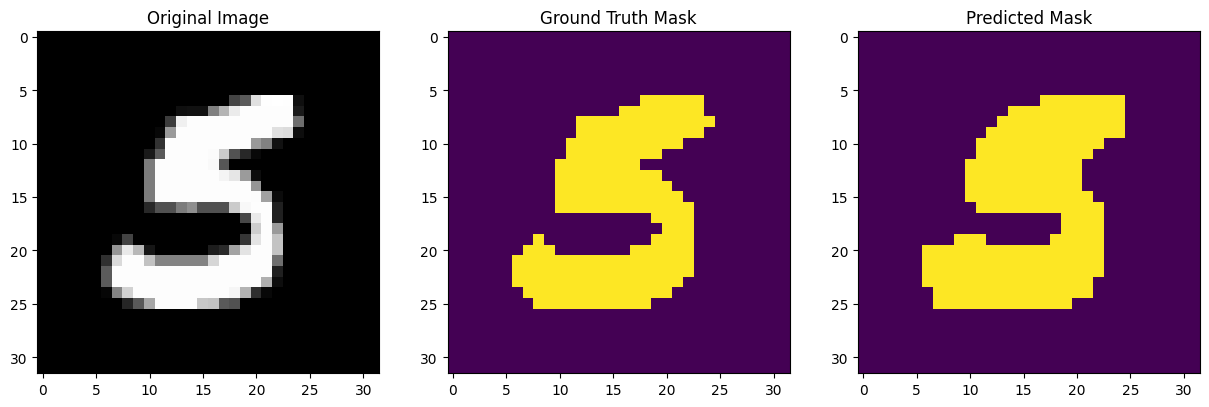

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


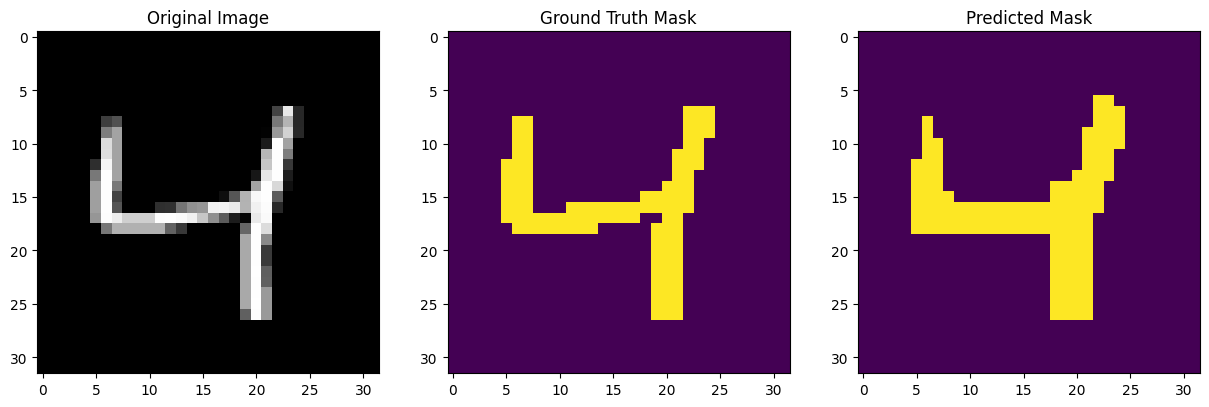

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


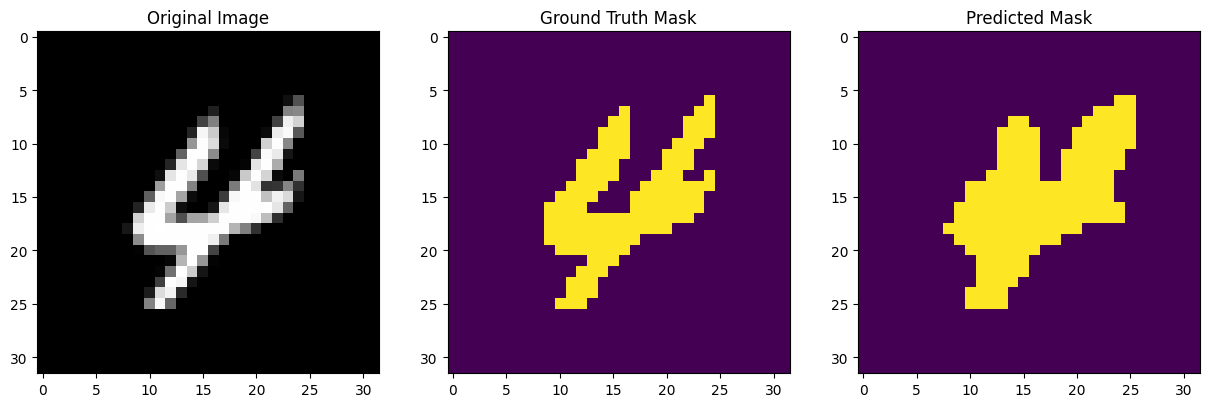

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


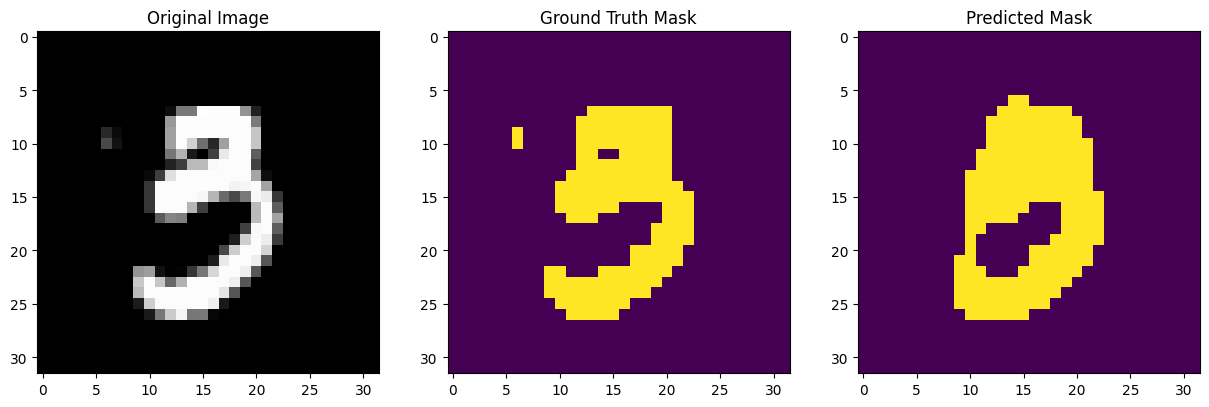

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


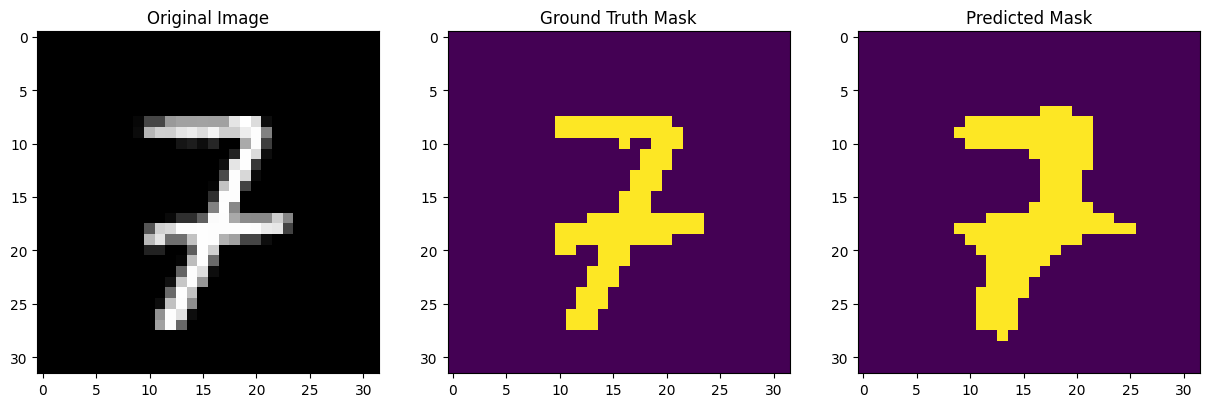

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


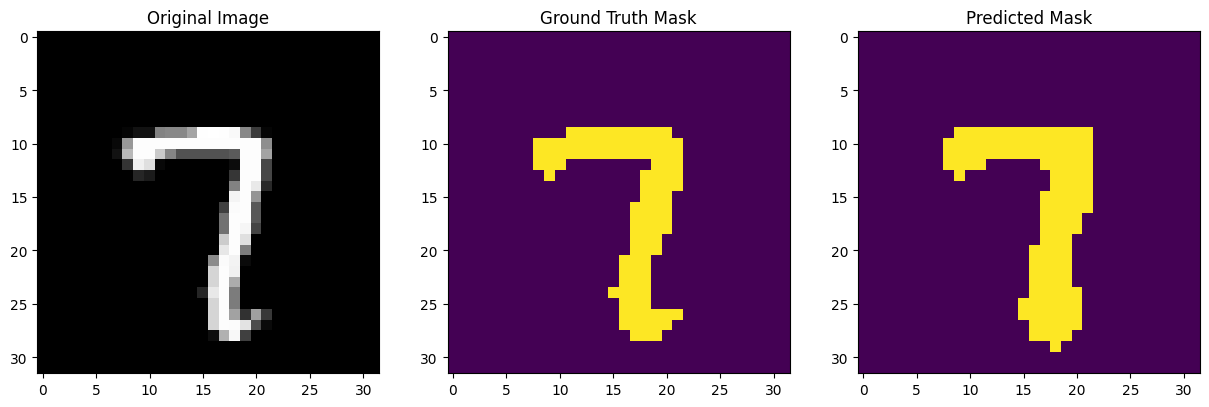

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


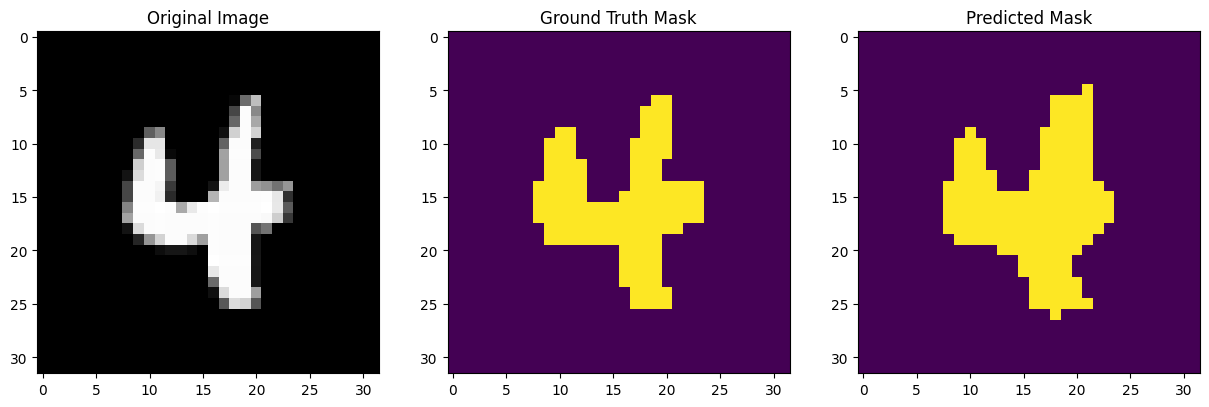

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


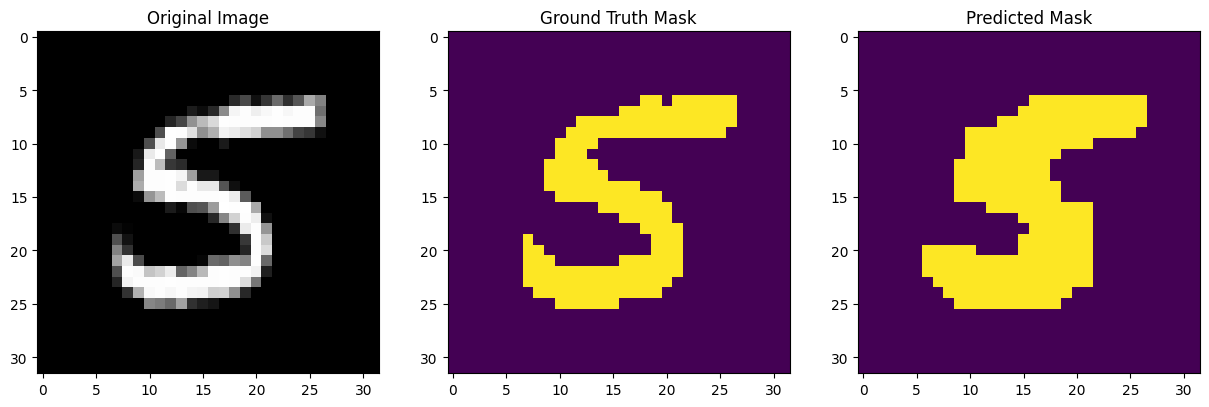

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


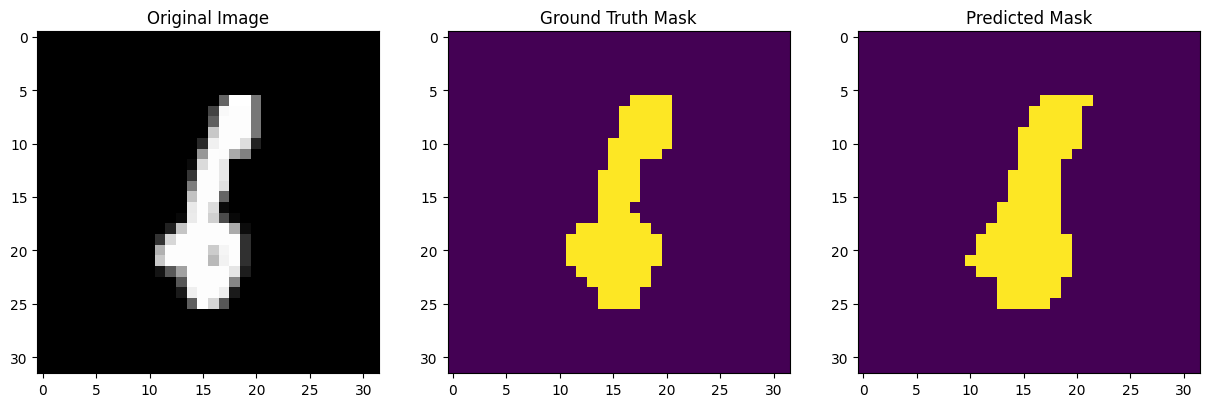

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


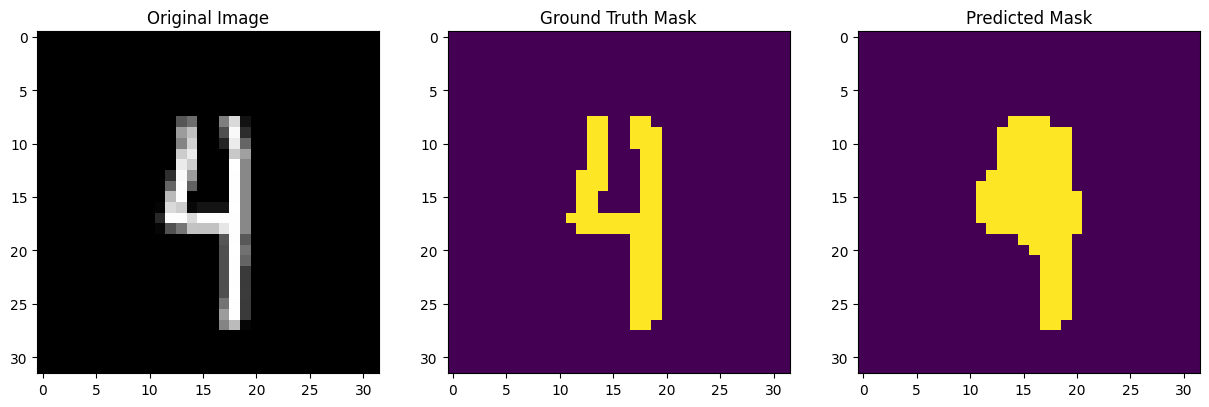

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


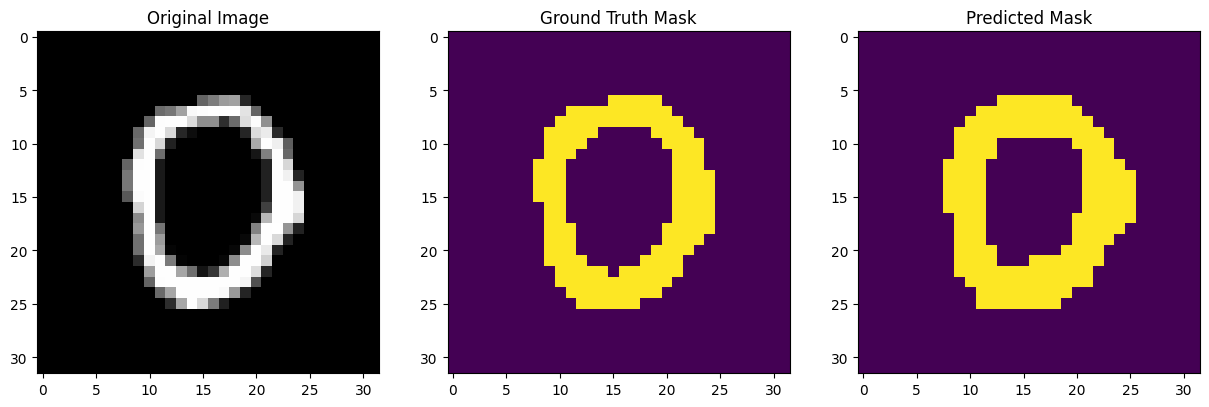

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


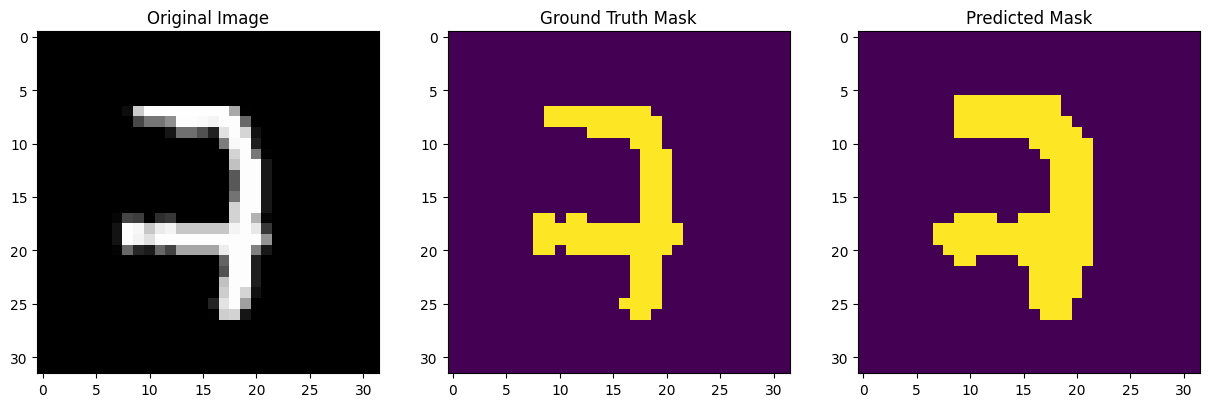

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


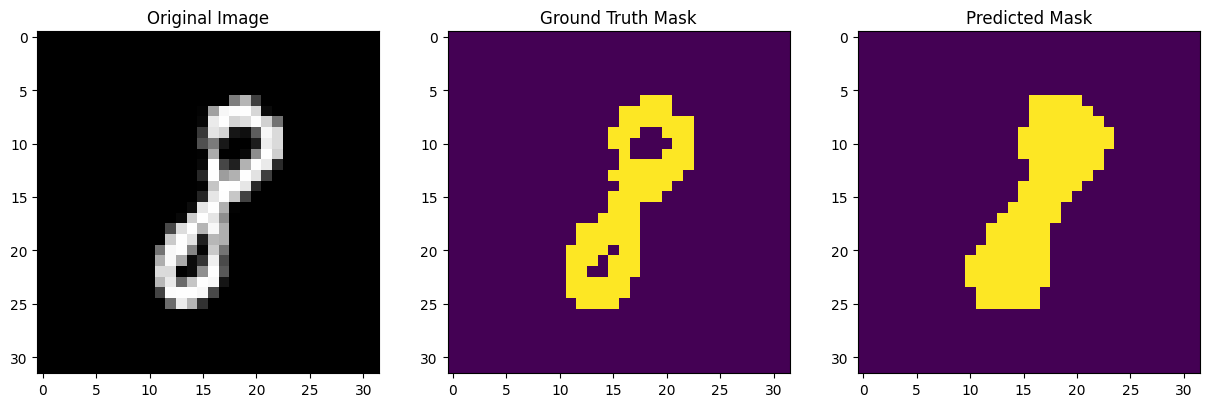

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


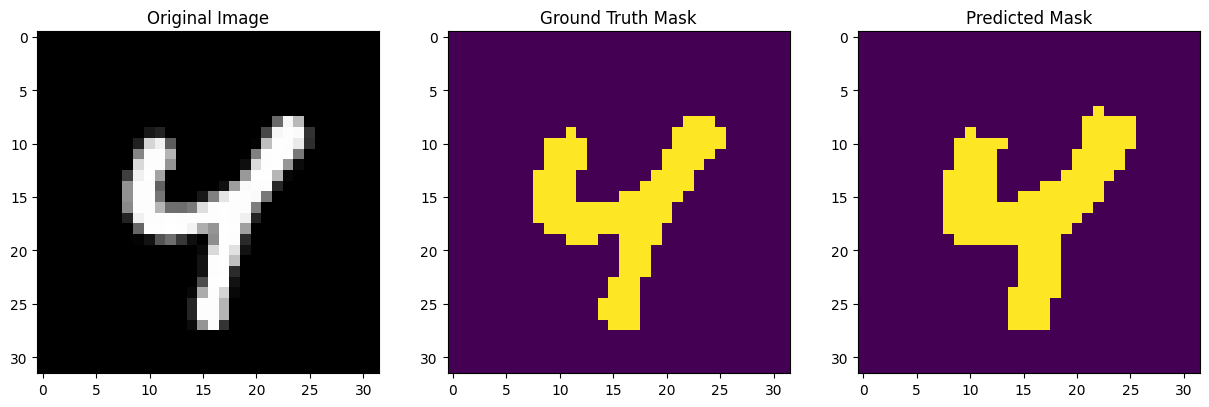

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


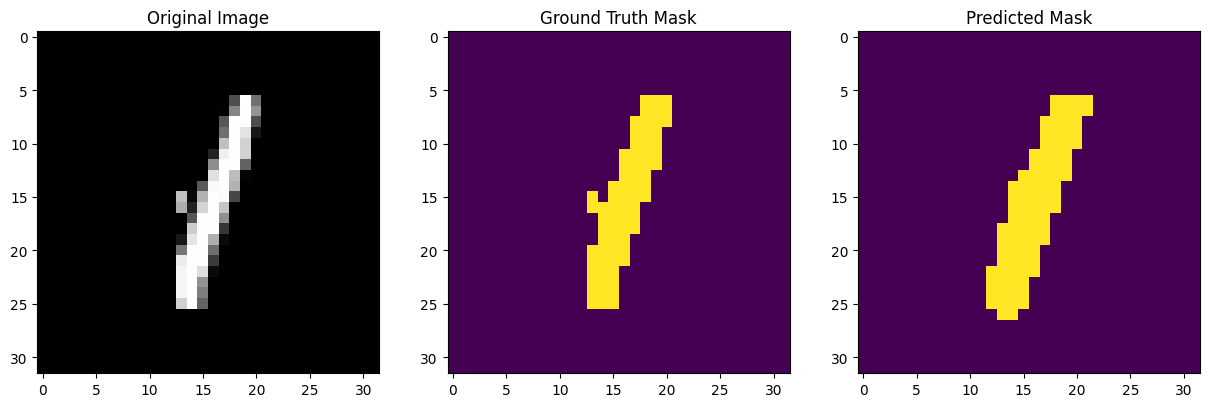

In [ ]:
# Визуализация

**Для 1 тыс и 50 эпох**

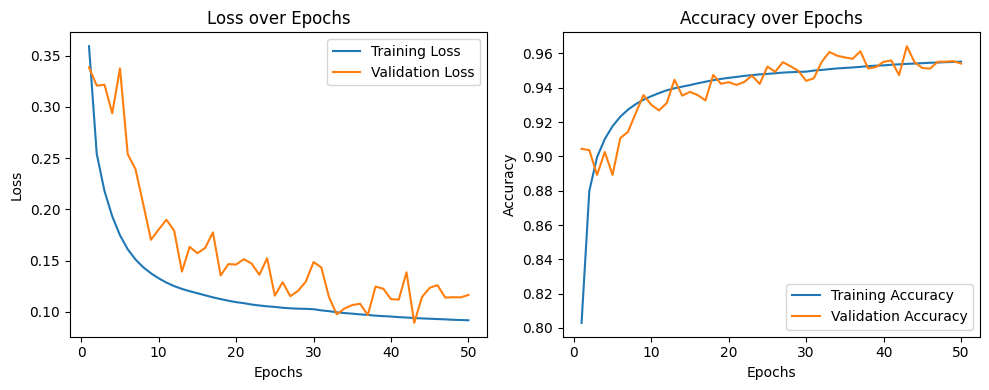

In [ ]:
# Accuracy и Loss

In [ ]:
# Метрики

Mean Precision: 0.8702
Mean Recall: 0.9684
Class 0: Precision = 0.9981, Recall = 0.9491
Class 1: Precision = 0.7424, Recall = 0.9878

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


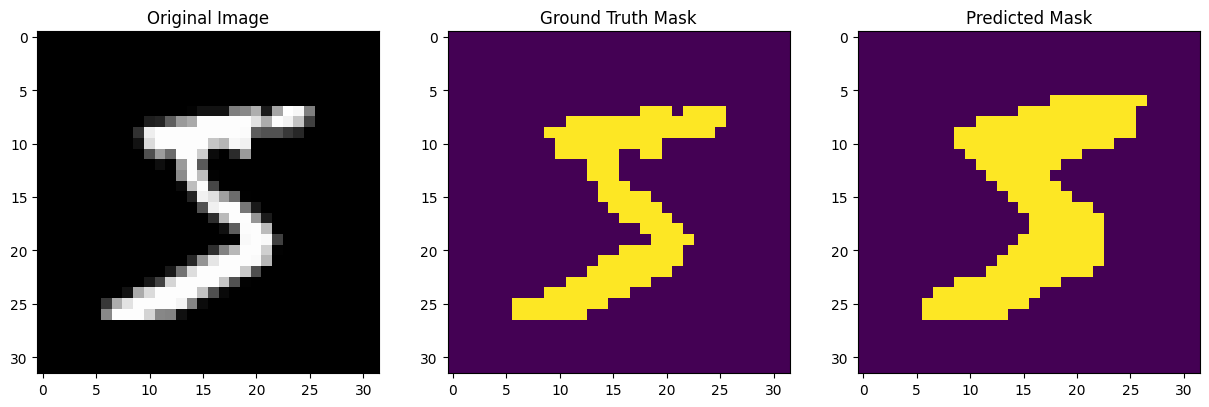

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


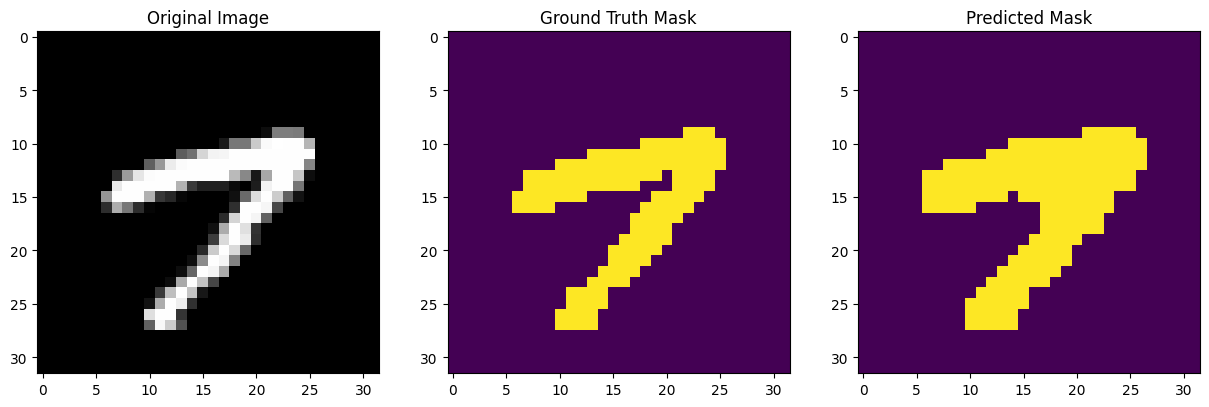

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


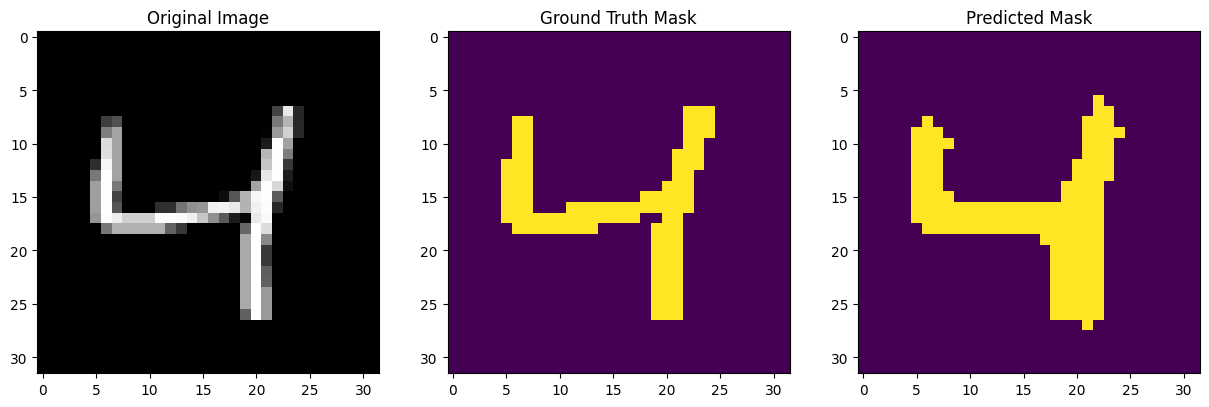

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


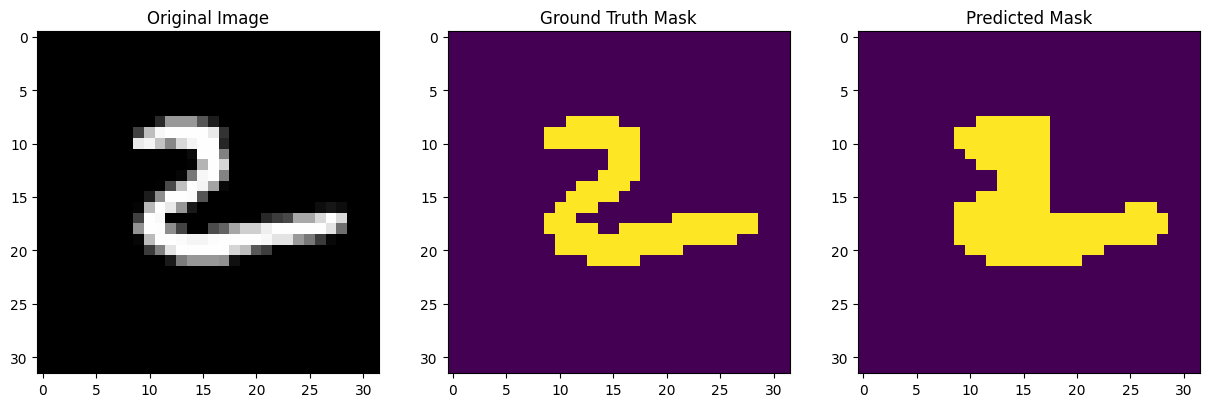

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


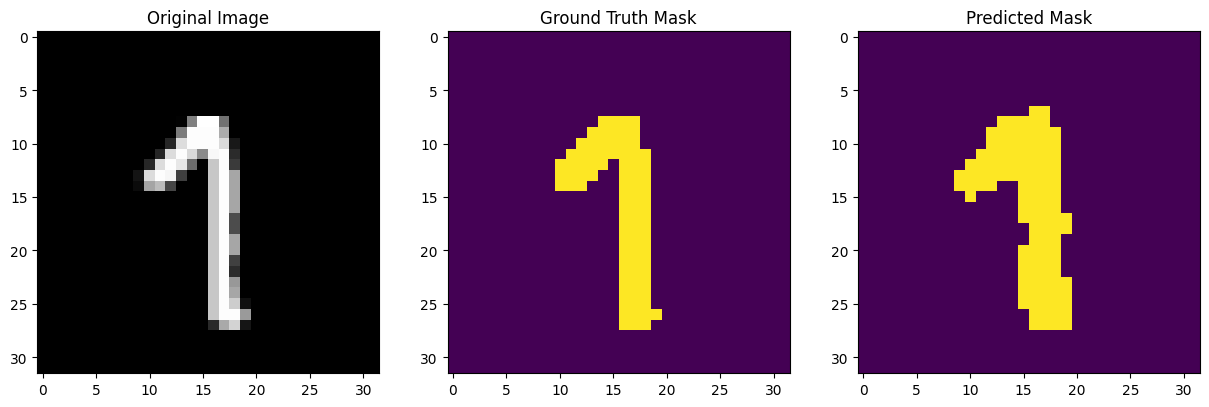

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


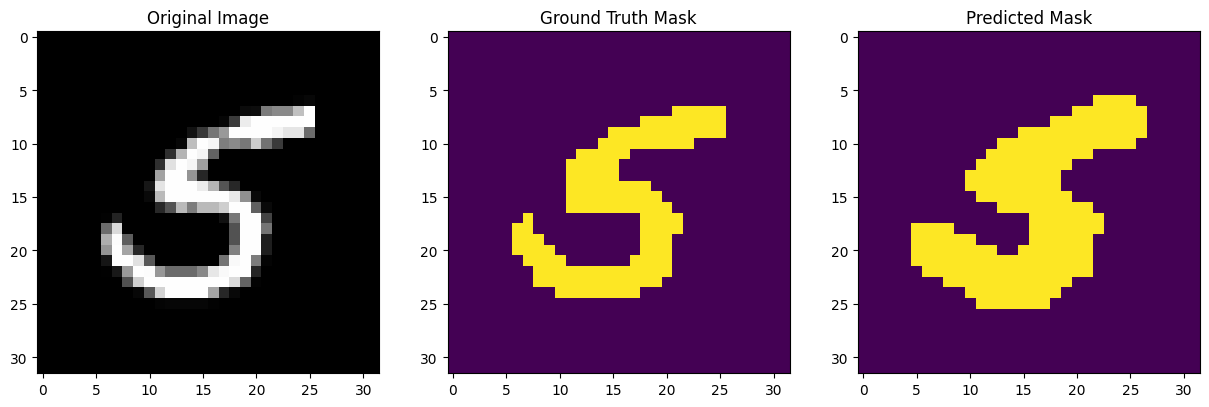

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


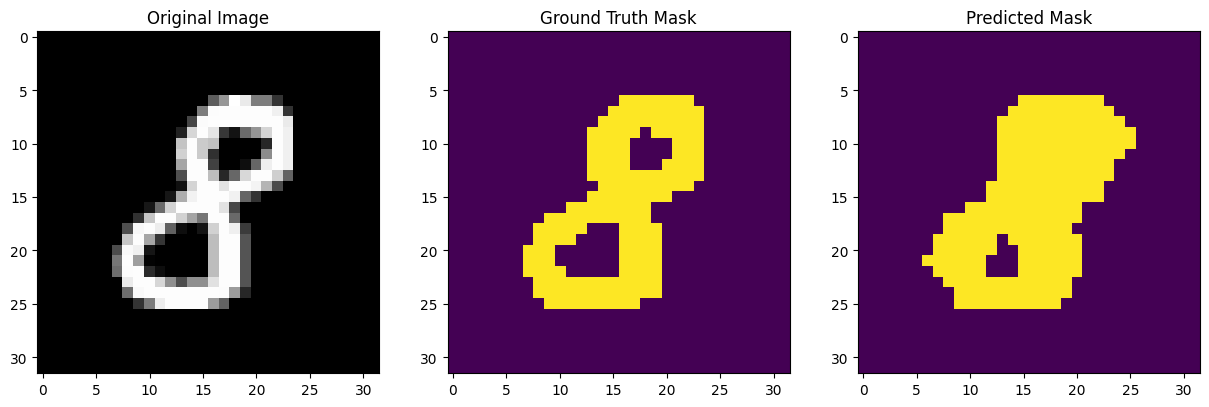

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


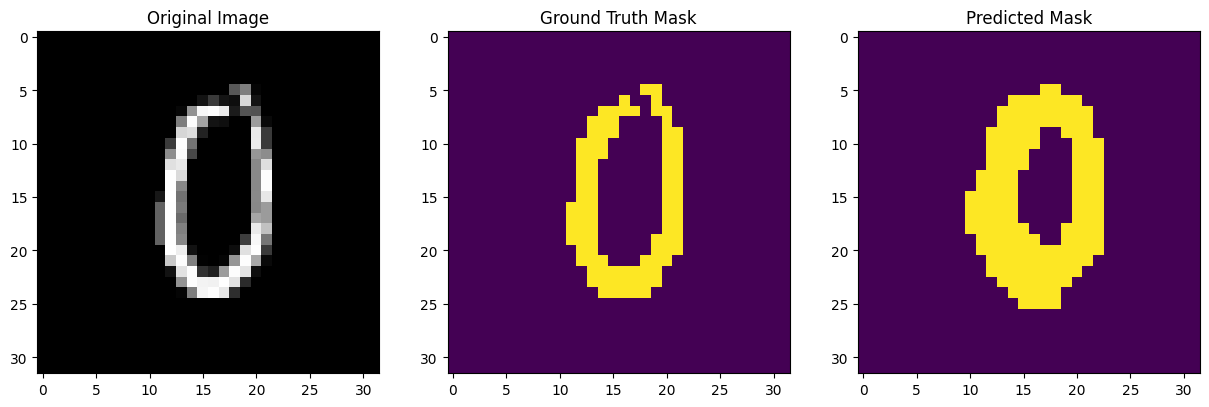

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


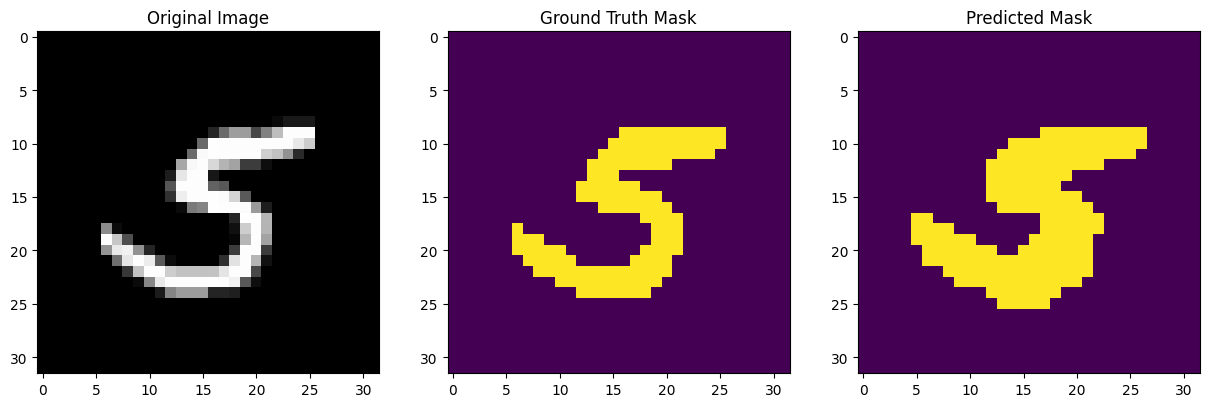

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


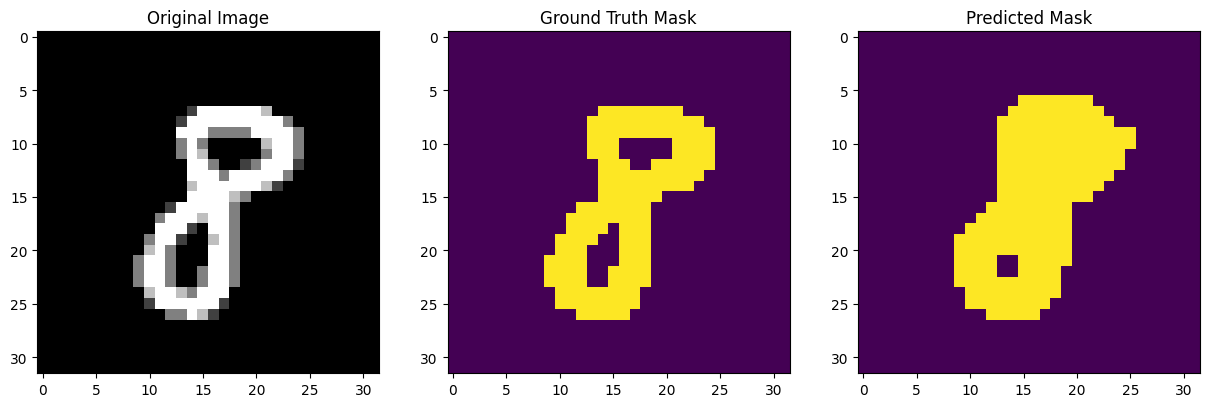

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


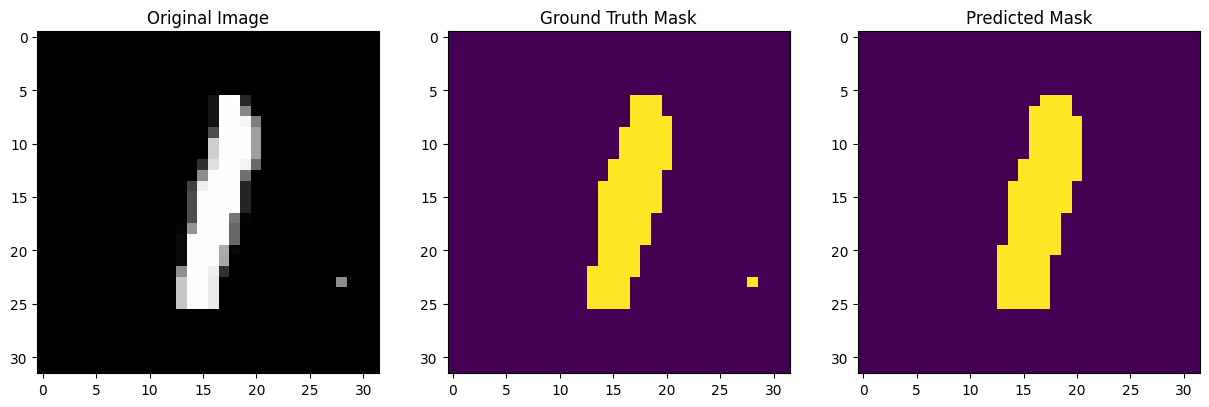

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


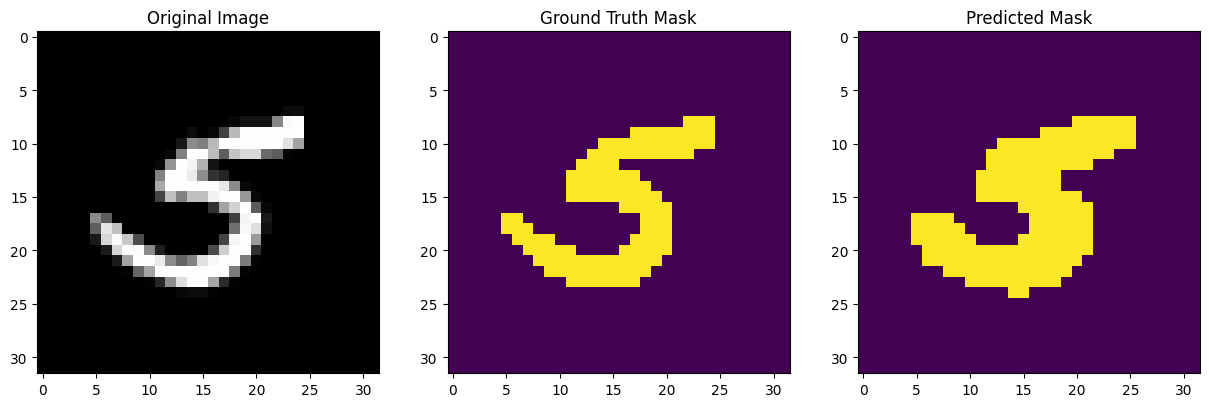

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


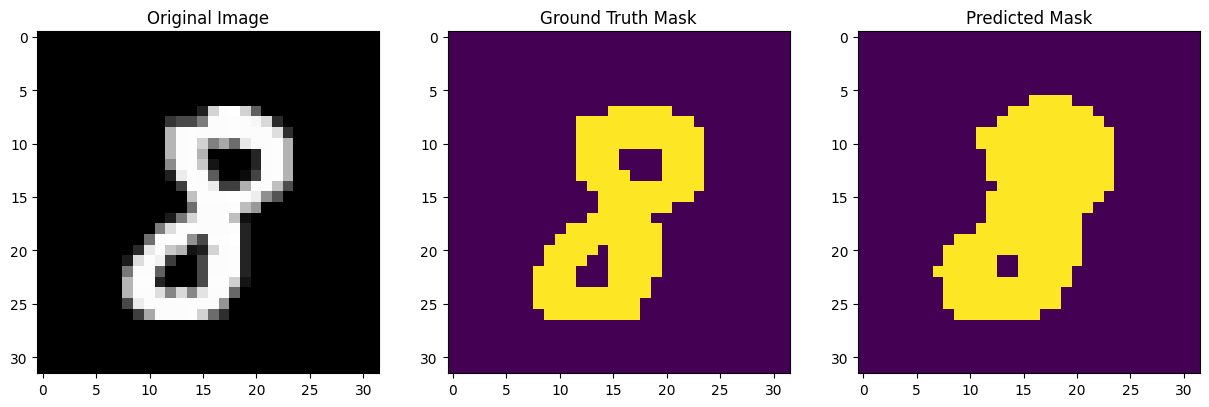

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


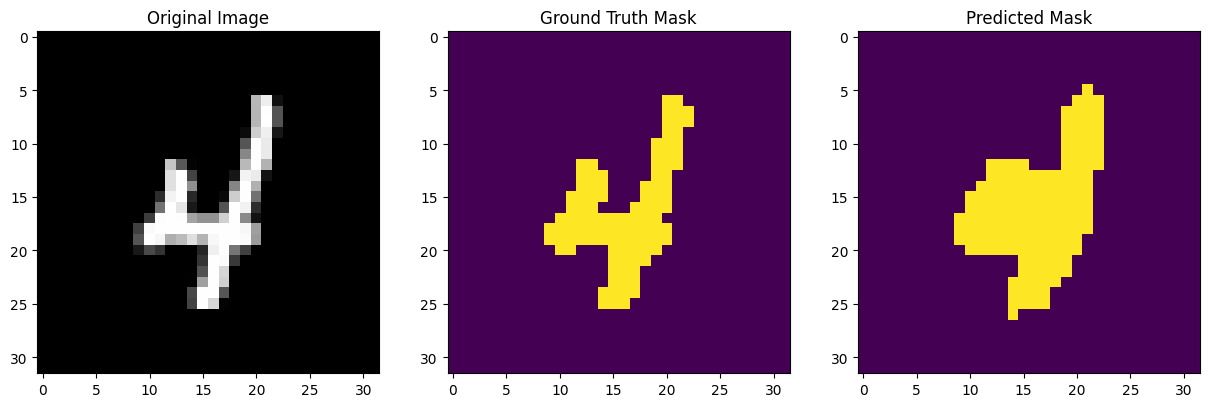

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


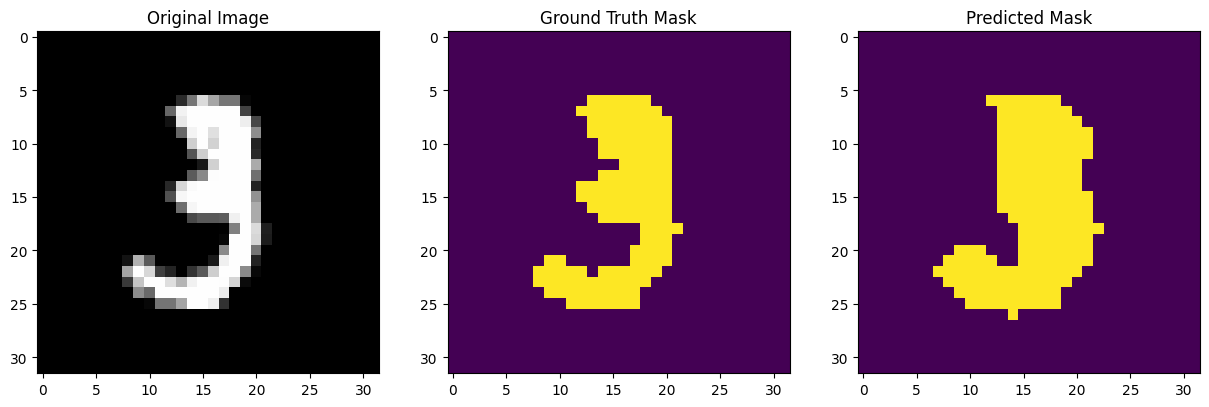

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


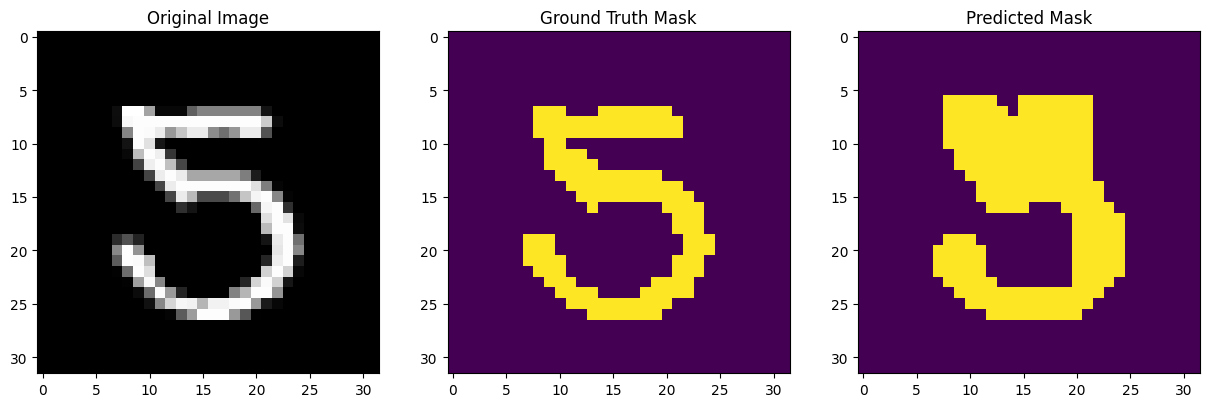

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


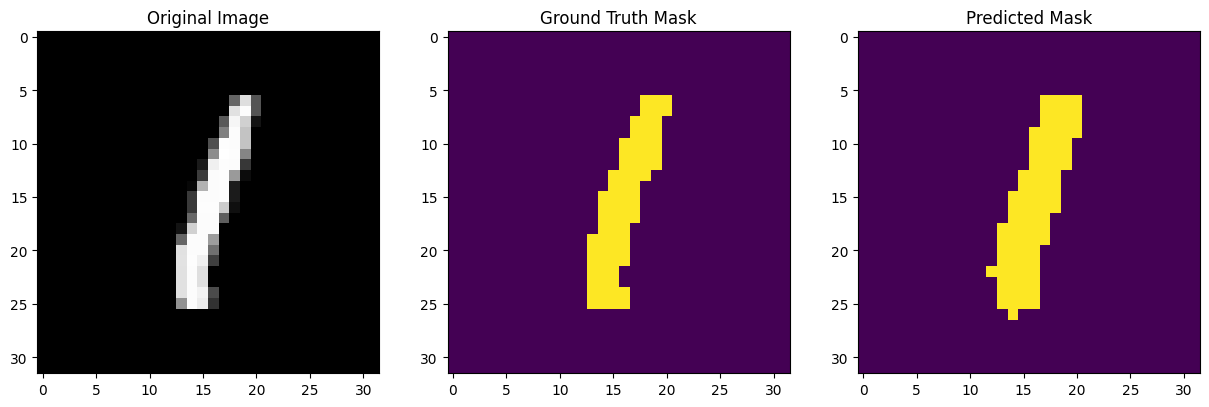

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


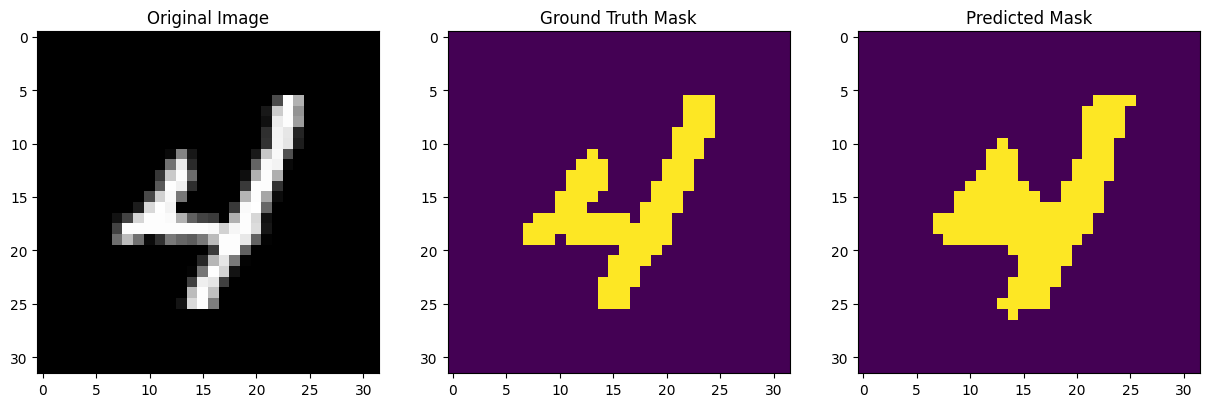

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


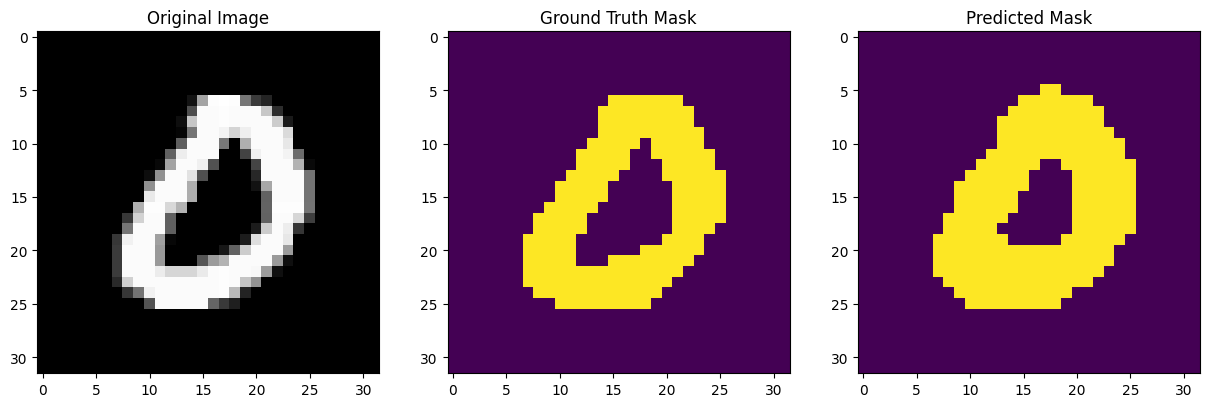

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


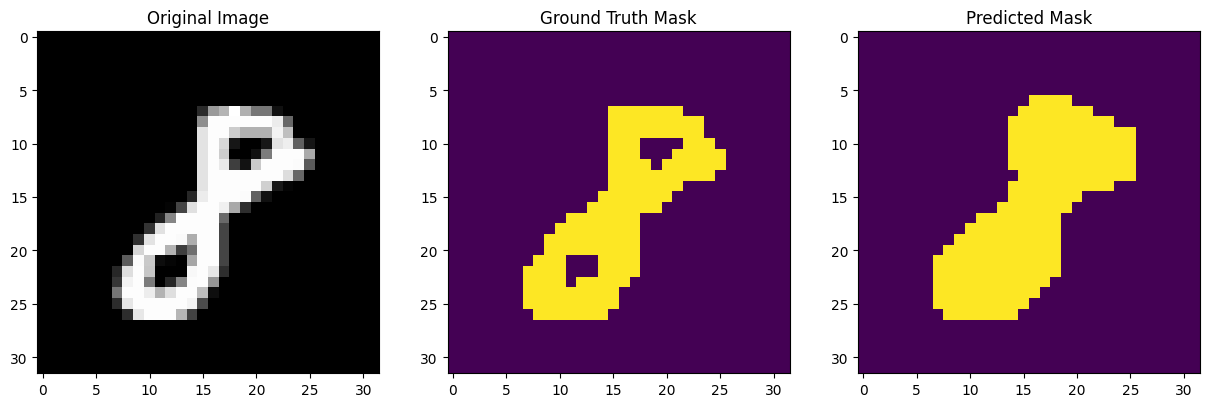

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


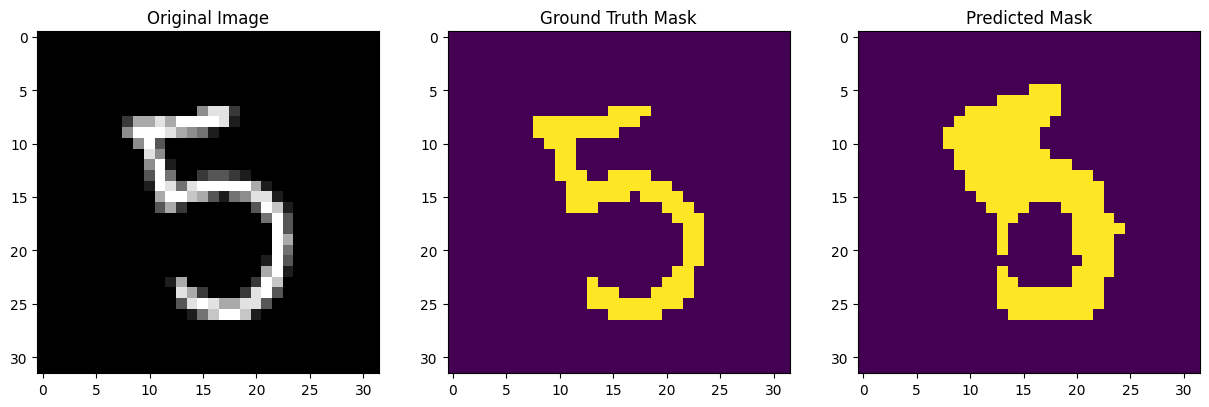

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


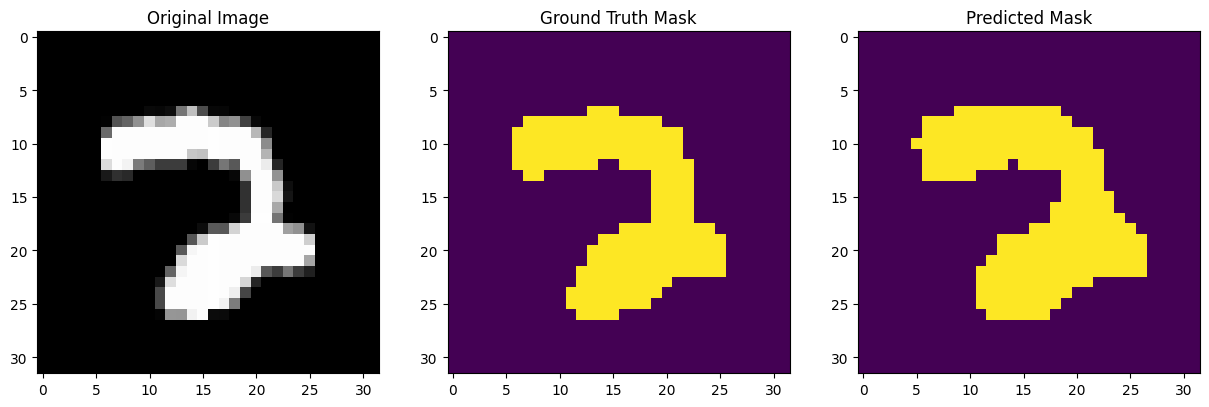

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


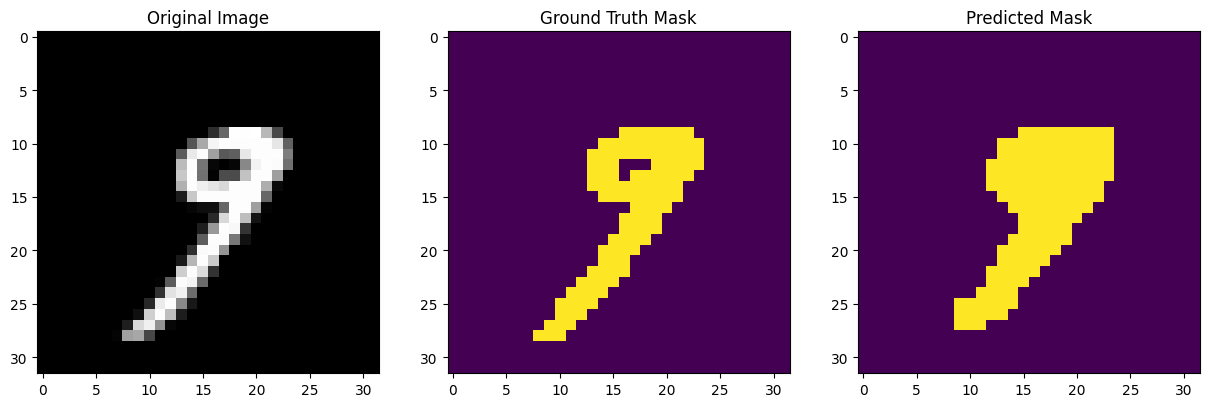

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


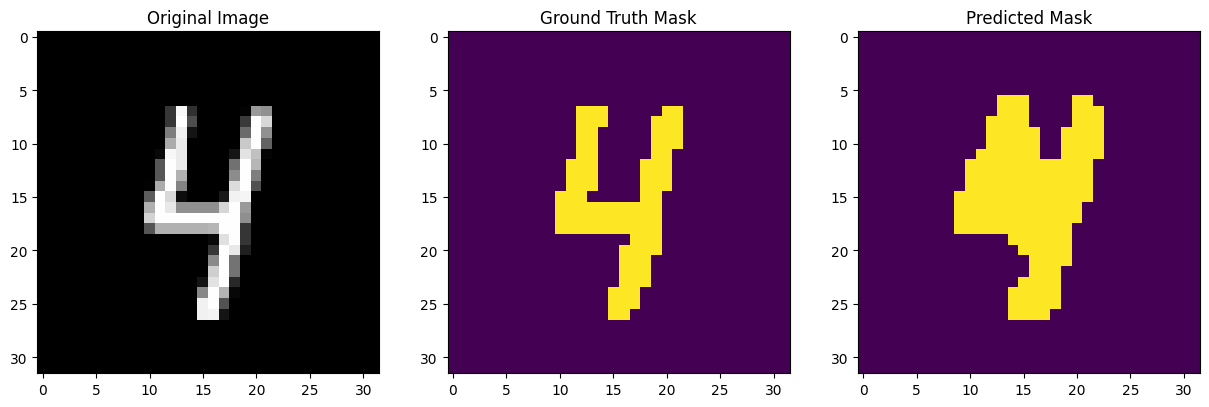

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


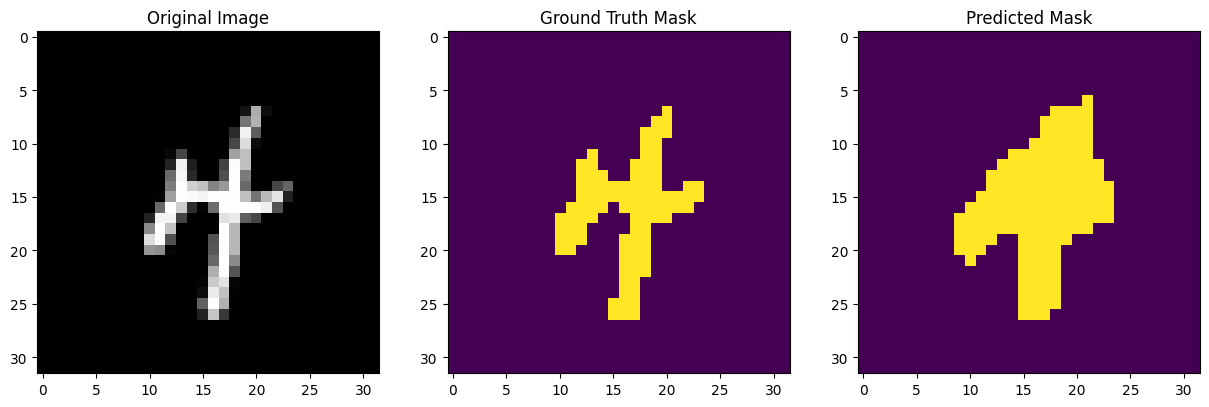

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


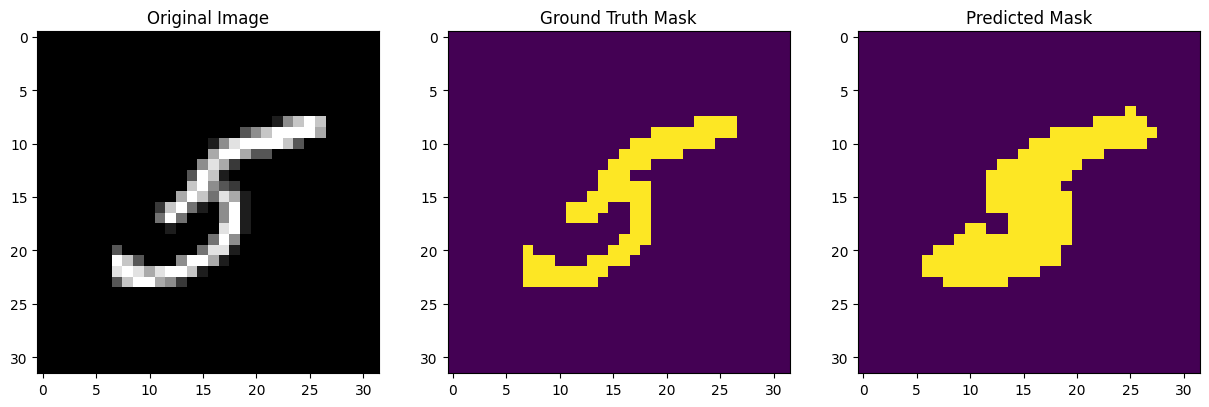

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


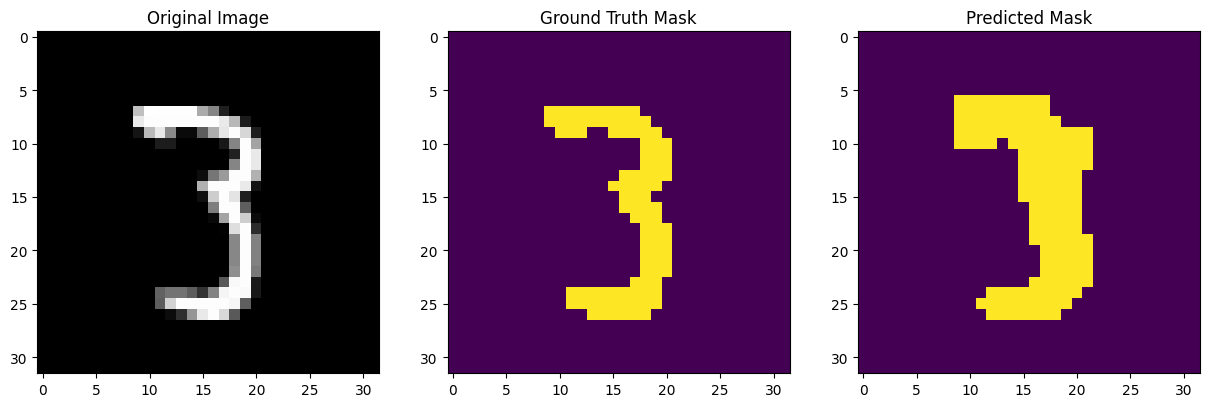

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


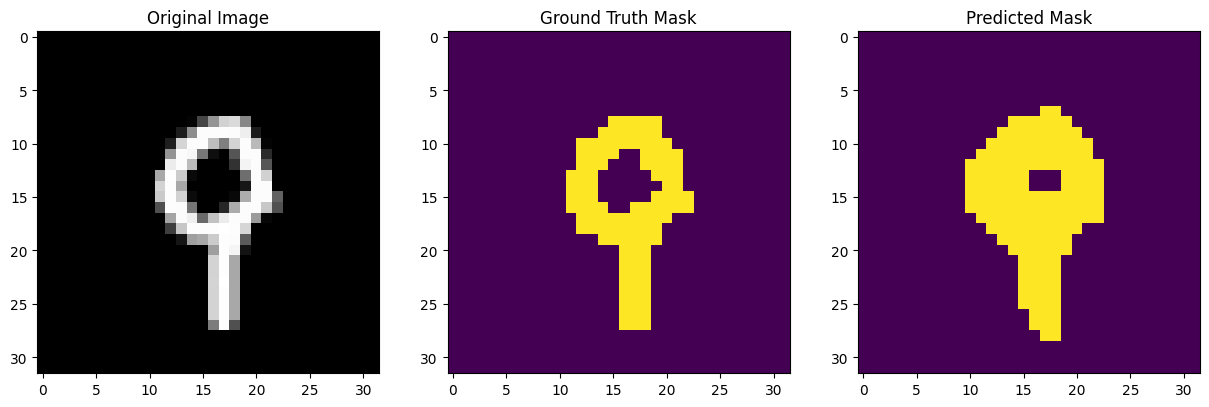

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


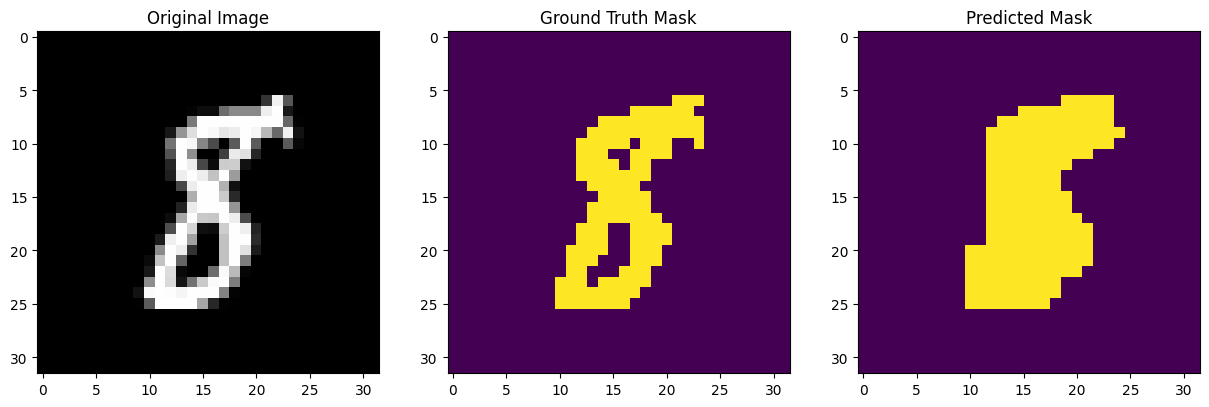

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


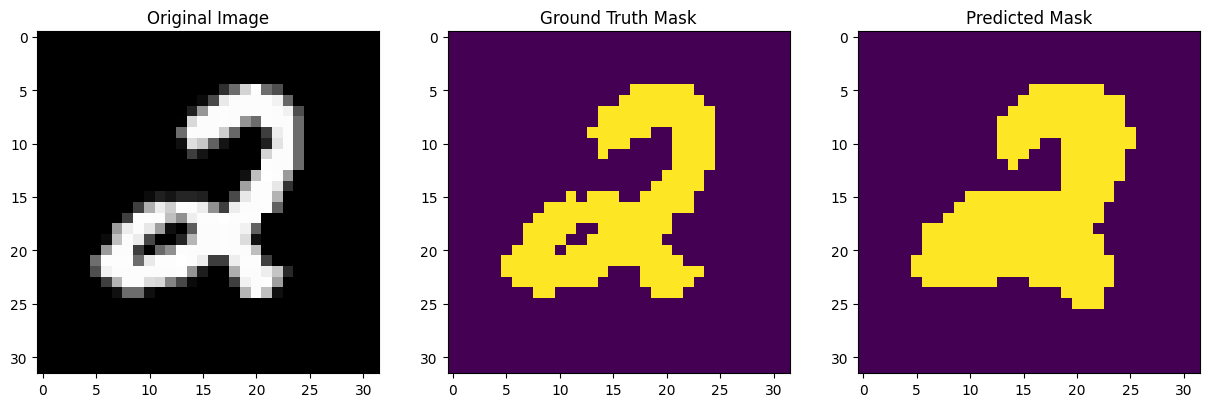

In [ ]:
# Визуализация

**Глобальный вывод из всего проекта такой**

Семантическая сегментация, скорее, не подходит для решения задачи.

Потому что надо так обучить нейросеть, чтобы метрики оказались не в районе 1, а были равны 1 (не относится к accuracy и loss). Только так можно получить попиксельную точность на маске предсказания.

Но этого добиться, скорее невозможно, чем возможно. Один шанс из миллиона.

